# Project Overview: Telco Customer Churn
---

**Group Alpha:**
- Amira Aqila Afdhal
- Christian
- Ditya Ayu Anjani

---

# A Guide to Reading This Notebook

In [5]:
# Code

<div class="alert alert-info">
    This is <b>Information</b>
</div>

<div class="alert alert-warning">
    This is <b>Warning</b>
</div>

<div class="alert alert-success">
    This is <b>Success</b>
</div>

---

# Problem Understanding
---

## Problem Statement
| No | Problem Statement |
|----|-------------------|
| 1 | Can we predict whether a customer will churn based on data set? |
| 2 | How can we improve the product to retain our customers? |

## Stakeholder
| Stakeholder | Description |
|-----|-----|
| Customer Retention Team |  Uses churn prediction to create targeted retention strategies |

## Goals

| No | Goals |
|----|-------------------|
| 1 | Predict Churn: Build a machine learning model to accurately classify customers likely to churn |
| 2 | Identify Churn Drivers: Understand which features (e.g., contract type, internet service, payment method) most influence churn |

## Evaluation Metic
Target variable:

`1` = Customer `churn` (discontinues subscription for a next period)

`0` = Customer did not `churn` (continues subscription for a next period)

**Confusion Matrix**
|                             | Prediction: Customer churns (1) | Prediksi: Customer stays (0) |
|-----------------------------|---------------------|----------------------------|
| **Actual: Customer churns (1)**       | True Positive (TP)  | False Negative (FN)        |
| **Actual: Customer stays (0)** | False Positive (FP) | True Negative (TN)         |


- **True Positive (TP)**: Customer actually churns and the model correctly predicts churn
- **False Positive (FP)**: Customer does not churn, but the model predicts churn → might trigger unnecessary retention efforts
- **False Negative (FN)**: Customer actually churns, but the model predicts no churn → risk of unexpected revenue loss
- **True Negative (TN)**: Customer does not churn and the model correctly predicts no churn

### Main focus: Minimize False Negatives (FN)
Since missing actual churners can lead to revenue loss and lower retention rate

Key metrics:
- **F<sub>2</sub> Score**: Prioritized because it emphasizes recall, helping us capture as many churners as possible for proactive retention
- **ROC AUC (Receiver Operating Characteristic - Area Under Curve)**: Used to back up model quality, showing how well the model distinguishes churners from non-churners across all thresholds

---

# Import Libraries
---

In [17]:
# Basic
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import warnings

warnings.filterwarnings("ignore")
# pd.set_option("display.max_columns", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_colwidth", 200)

# Test
from scipy.stats import normaltest, chi2_contingency, ttest_ind
from scipy import stats

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
import category_encoders as ce
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectPercentile
from sklearn.svm import SVC

# Imbalance Dataset
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, NearMiss

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
)
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb

# Evaluation
from sklearn.model_selection import (
    cross_validate,
    GridSearchCV,
    StratifiedKFold,
    train_test_split,
    cross_val_score,
    cross_val_predict,
)
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import (
    make_scorer,
    fbeta_score,
    recall_score,
    precision_score,
    balanced_accuracy_score,
)
from sklearn.metrics import roc_auc_score, RocCurveDisplay
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import VotingClassifier, RandomForestClassifier


import pickle

---

# Data Understanding
Data source: https://www.kaggle.com/datasets/blastchar/telco-customer-churn

---

## Read Data Set

In [21]:
base = pd.read_csv("dataset/WA_Fn-UseC_-Telco-Customer-Churn.csv")
base

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


<div class="alert alert-info">Read the main dataset that was provided at the beginning of the final project.</div>

In [23]:
status = pd.read_csv("dataset/Tambahan/Telco_customer_churn_status.csv", sep=";")
status = status[["Customer ID", "Satisfaction Score", "CLTV"]]
status

,Customer ID,Satisfaction Score,CLTV
0,8779-QRDMV,3,5433
1,7495-OOKFY,3,5302
2,1658-BYGOY,2,3179
3,4598-XLKNJ,2,5337
4,4846-WHAFZ,2,2793
...,...,...,...
7038,2569-WGERO,5,5306
7039,6840-RESVB,3,2140
7040,2234-XADUH,4,5560
7041,4801-JZAZL,4,2793


<div class="alert alert-info">Read the status dataset that was found on the internet.</div>

In [25]:
demographic = pd.read_csv(
    "dataset/Tambahan/Telco_customer_churn_demographics.csv", sep=";"
)
demographic = demographic[["Customer ID", "Under 30"]]
demographic

,Customer ID,Under 30
0,8779-QRDMV,No
1,7495-OOKFY,No
2,1658-BYGOY,No
3,4598-XLKNJ,No
4,4846-WHAFZ,No
...,...,...
7038,2569-WGERO,No
7039,6840-RESVB,No
7040,2234-XADUH,No
7041,4801-JZAZL,No


<div class="alert alert-info">Read the demographics dataset that was found on the internet.</div>

In [27]:
# Join all table
df = base.merge(status, left_on="customerID", right_on="Customer ID", how="left").merge(
    demographic, left_on="customerID", right_on="Customer ID", how="left"
)

df = df[
    [
        "customerID",
        "gender",
        "Under 30",
        "SeniorCitizen",
        "Partner",
        "PhoneService",
        "MultipleLines",
        "InternetService",
        "OnlineSecurity",
        "OnlineBackup",
        "DeviceProtection",
        "TechSupport",
        "StreamingTV",
        "StreamingMovies",
        "Contract",
        "PaperlessBilling",
        "PaymentMethod",
        "tenure",
        "MonthlyCharges",
        "TotalCharges",
        "CLTV",
        "Satisfaction Score",
        "Churn",
    ]
]

df.sample(5)

,customerID,gender,Under 30,SeniorCitizen,Partner,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,tenure,MonthlyCharges,TotalCharges,CLTV,Satisfaction Score,Churn
697,5896-NPFWW,Male,Yes,0,Yes,Yes,No,DSL,No,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,3,50.15,168.15,3273,1,Yes
3392,7636-PEPNS,Female,No,0,Yes,Yes,No,DSL,No,No,No,No,No,No,One year,Yes,Mailed check,58,44.10,2413.05,5040,4,No
3463,9576-SYUHJ,Male,Yes,0,No,Yes,Yes,Fiber optic,Yes,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,37,91.15,3369.25,3194,3,No
939,0347-UBKUZ,Female,No,0,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,15,19.90,320.45,3366,4,No
6368,2720-WGKHP,Male,No,1,No,Yes,Yes,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,2,94.00,181.7,5569,1,Yes


<div class="alert alert-info">Merge all the prepared datasets.</div>

### Feature Information

| Feature Name       | Statistical Type          | Description                                                      |
| ------------------ | ------------------------- | ---------------------------------------------------------------- |
| customerID         | Identifier                | Unique identifier for each customer                              |
| gender             | Qualitative – Nominal     | Customer's gender                                                |
| Under 30           | Qualitative – Nominal     | Whether the customer is under 30 years old                       |
| SeniorCitizen      | Qualitative – Nominal     | Whether the customer is a senior citizen (1 = Yes, 0 = No)       |
| Partner            | Qualitative – Nominal     | Whether the customer has a partner                               |
| PhoneService       | Qualitative – Nominal     | Whether the customer has phone service                           |
| MultipleLines      | Qualitative – Nominal     | Whether the customer has multiple phone lines                    |
| InternetService    | Qualitative – Nominal     | Type of internet service (DSL, Fiber optic, None)                |
| OnlineSecurity     | Qualitative – Nominal     | Whether the customer has online security service                 |
| OnlineBackup       | Qualitative – Nominal     | Whether the customer has online backup service                   |
| DeviceProtection   | Qualitative – Nominal     | Whether the customer has device protection service               |
| TechSupport        | Qualitative – Nominal     | Whether the customer has tech support service                    |
| StreamingTV        | Qualitative – Nominal     | Whether the customer has streaming TV service                    |
| StreamingMovies    | Qualitative – Nominal     | Whether the customer has streaming movie service                 |
| Contract           | Qualitative – Ordinal     | Customer's contract type (Month-to-month, One year, Two year)    |
| PaperlessBilling   | Qualitative – Nominal     | Whether the customer is on paperless billing                     |
| PaymentMethod      | Qualitative – Nominal     | Customer's payment method (e.g., Electronic check, Mailed check) |
| tenure             | Quantitative – Discrete   | Number of months the customer has stayed with the company        |
| MonthlyCharges     | Quantitative – Continuous | The amount charged to the customer monthly                       |
| TotalCharges       | Quantitative – Continuous | The total amount charged to the customer                         |
| CLTV               | Quantitative – Continuous | Customer Lifetime Value                                          |
| Satisfaction Score | Qualitative – Ordinal     | Customer satisfaction rating                                     |
| Churn              | Qualitative – Nominal     | Whether the customer churned (Yes or No)                         |


### Feature Grouping

| Customer Profile | Service Subscription | Account & Billing | Customer Value & Satisfaction | Churn Outcome |
|--------------|--------------|--------------|--------------|--------------|
| customerID | PhoneService | Contract | CLTV | Churn |
| gender | MultipleLines | PaperlessBilling | Population |  |
| Under 30 | InternetService | PaymentMethod |  |  |
| SeniorCitizen | OnlineSecurity | MonthlyCharges |  |  |
| Partner | OnlineBackup | TotalCharges |  |  |
|  | DeviceProtection | Tenure |  |  |
|  | TechSupport |  |  |  |
|  | StreamingTv |  |  |  |
|  | StreamingMovies |  |  |  |

#### Target Variable
- `Churn` — Indicates whether the customer has churned (`Yes` or `No`)

---

## Data Preparation

### Handle missing values, invalid entries, or incorrect data types

In [36]:
df_check = pd.DataFrame(
    {
        "Features": df.columns,
        "Data Type": df.dtypes.values,
        "Data Count": df.count().values,
        "Null Value Count": df.isnull().sum().values,
        "Number of Unique Value": df.nunique().values,
        "Min Value": [
            df[col].min() if pd.api.types.is_numeric_dtype(df[col]) else ""
            for col in df.columns
        ],
        "Max Value": [
            df[col].max() if pd.api.types.is_numeric_dtype(df[col]) else ""
            for col in df.columns
        ],
        "Unique Value": [df[col].unique() for col in df.columns],
    }
)

display(df_check)

,Features,Data Type,Data Count,Null Value Count,Number of Unique Value,Min Value,Max Value,Unique Value
0,customerID,object,7043,0,7043,,,"[7590-VHVEG, 5575-GNVDE, 3668-QPYBK, 7795-CFOCW, 9237-HQITU, 9305-CDSKC, 1452-KIOVK, 6713-OKOMC, 7892-POOKP, 6388-TABGU, 9763-GRSKD, 7469-LKBCI, 8091-TTVAX, 0280-XJGEX, 5129-JLPIS, 3655-SNQYZ, 819..."
1,gender,object,7043,0,2,,,"[Female, Male]"
2,Under 30,object,7043,0,2,,,"[No, Yes]"
3,SeniorCitizen,int64,7043,0,2,0,1,"[0, 1]"
4,Partner,object,7043,0,2,,,"[Yes, No]"
5,PhoneService,object,7043,0,2,,,"[No, Yes]"
6,MultipleLines,object,7043,0,3,,,"[No phone service, No, Yes]"
7,InternetService,object,7043,0,3,,,"[DSL, Fiber optic, No]"
8,OnlineSecurity,object,7043,0,3,,,"[No, Yes, No internet service]"
9,OnlineBackup,object,7043,0,3,,,"[Yes, No, No internet service]"


<div class="alert alert-warning">
    <ul>
        <li><b>SeniorCitizen</b> should be of type <b>object</b>, as it represents <b>categorical</b> values—typically 'Yes' or 'No'.</li>
        <li><b>TotalCharges</b> is expected to be a numerical variable of type <b>float</b>, but it appears as <b>object</b> due to formatting issues—likely caused by blank or non-numeric values.</li>
        <li><b>Satisfaction Score</b> should be treated as an <b>ordinal categorical</b> variable, with ordered values of 1, 2, 3, 4, and 5.</li>
    </ul>
</div>

In [38]:
df["SeniorCitizen"] = df["SeniorCitizen"].map({0: "No", 1: "Yes"})

<div class="alert alert-success">Convert <b>SeniorCitizen</b> to Yes and No types for proper representation and analysis</div>

In [40]:
df[pd.to_numeric(df["TotalCharges"], errors="coerce").isna()]

,customerID,gender,Under 30,SeniorCitizen,Partner,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,tenure,MonthlyCharges,TotalCharges,CLTV,Satisfaction Score,Churn
488,4472-LVYGI,Female,No,No,Yes,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),0,52.55,,2578,3,No
753,3115-CZMZD,Male,Yes,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0,20.25,,5504,4,No
936,5709-LVOEQ,Female,No,No,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,0,80.85,,2048,3,No
1082,4367-NUYAO,Male,No,No,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0,25.75,,4950,5,No
1340,1371-DWPAZ,Female,No,No,Yes,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),0,56.05,,4740,4,No
3331,7644-OMVMY,Male,No,No,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0,19.85,,2019,3,No
3826,3213-VVOLG,Male,Yes,No,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0,25.35,,2299,4,No
4380,2520-SGTTA,Female,Yes,No,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0,20.00,,3763,4,No
5218,2923-ARZLG,Male,No,No,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,0,19.70,,4890,5,No
6670,4075-WKNIU,Female,Yes,No,Yes,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,0,73.35,,2342,4,No


<div class="alert alert-warning">
    We find that the reason TotalCharges is classified as an object is due to the presence of rows containing empty strings (" "), which account for only 0.16% of the dataset
</div>

In [42]:
df = df[df["TotalCharges"] != " "]

<div class="alert alert-success">We remove rows where the TotalCharges value is blank (i.e., equal to ' '), as these entries represent invalid or missing data</div>

In [44]:
df[["TotalCharges"]] = df[["TotalCharges"]].astype(float)

<div class="alert alert-success">Change data type from int to float to enable decimal precision in calculations</div>

In [46]:
df["Satisfaction Score"] = pd.Categorical(
    df["Satisfaction Score"], categories=[1, 2, 3, 4, 5], ordered=True
)

<div class="alert alert-success">Change data type from int to object to make it qualitative</div>

### Handle Outlier

<div class="alert alert-info">
    Check how many rows are affected by outliers using the following rule:<br>
    "<b>Values greater than Q3 + 1.5 × IQR (Interquartile Range) or less than Q1 − 1.5 × IQR are considered outliers.</b>"
</div>

In [50]:
outlier_counts = {}
for col in df.select_dtypes(include=[np.number]).columns:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    outliers = df[(df[col] < lower) | (df[col] > upper)].shape[0]
    outlier_counts[col] = outliers

outlier_df = pd.DataFrame.from_dict(
    outlier_counts, orient="index", columns=["Outlier Count"]
)

outlier_df.sort_values(by="Outlier Count", ascending=False)

,Outlier Count
tenure,0
MonthlyCharges,0
TotalCharges,0
CLTV,0


<div class="alert alert-success">
    No outliers are detected in the dataset
</div>

### Handle Duplicate

In [53]:
pd.DataFrame(df.duplicated().value_counts())

,count
False,7032


<div class="alert alert-success">
    No duplicate are detected in the dataset
</div>

### Create Column

In [56]:
df["AgeGroup"] = pd.NA
df.loc[df["Under 30"] == "Yes", "AgeGroup"] = "Under 30"
df.loc[(df["Under 30"] == "No") & (df["SeniorCitizen"] == "No"), "AgeGroup"] = (
    "Middle Age (30–59)"
)
df.loc[df["SeniorCitizen"] == "Yes", "AgeGroup"] = "Senior (≥ 60)"

# Set AgeGroup as categorical with order
df["AgeGroup"] = pd.Categorical(
    df["AgeGroup"],
    categories=["Under 30", "Middle Age (30–59)", "Senior (≥ 60)"],
    ordered=True,
)

<div class="alert alert-info">We create the AgeGroup column to segment customers into three meaningful age-based categories: Under 30, Middle Age (30–59), and Senior Citizens (60 and above). This segmentation helps us analyze behavioral patterns and churn risk across different life stages. Younger customers may prioritize flexibility and technology-driven services, middle-aged customers often represent stable, long-term users, and senior citizens may have distinct support needs or pricing sensitivities. By defining these groups, we enable more targeted insights and customer-specific strategies for retention, engagement, and service optimization</div>

---

# Exploratory Data Analysis (EDA)

---

## Quantitative Data Distribution Analysis (Boxplot, Histogram, QQPlot)

In [61]:
def showQuantiDist(col):
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))

    # Histogram with Set2 palette (manually apply color)
    sns.histplot(
        df[col].dropna(), ax=axes[0], kde=True, color=sns.color_palette("Set2")[0]
    )
    axes[0].set_title(f"Histogram of {col}")

    # Boxplot with Set2 palette
    sns.boxplot(x=df[col], ax=axes[1], color=sns.color_palette("Set2")[1])
    axes[1].set_title(f"Boxplot of {col}")

    # QQPlot (color not directly applicable, but set manually)
    stats.probplot(df[col].dropna(), dist="norm", plot=axes[2])
    axes[2].get_lines()[0].set_color(sns.color_palette("Set2")[2])  # Data points
    axes[2].get_lines()[1].set_color("black")  # QQ line
    axes[2].set_title(f"QQ Plot of {col}")

    fig.tight_layout()
    plt.show()

    # Inferential Analysis
    churned = df[df["Churn"] == "Yes"][col]
    not_churned = df[df["Churn"] == "No"][col]
    t_stat, p = ttest_ind(churned, not_churned, equal_var=False)

    ttest_result = {
        "Feature": col,
        "t-statistic": round(t_stat, 2),
        "p-value": round(p, 4),
        "Significant (p < 0.05)": p < 0.05,
    }
    display(pd.DataFrame([ttest_result]))

### Tenure

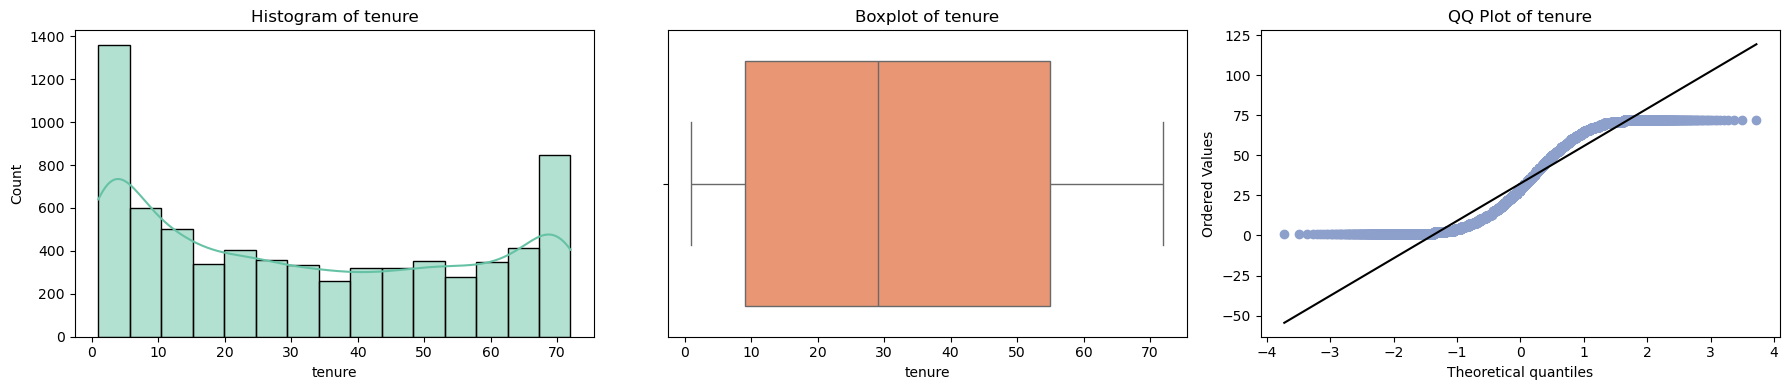

,Feature,t-statistic,p-value,Significant (p < 0.05)
0,tenure,-34.97,0.0,True


In [63]:
showQuantiDist("tenure")

<div class="alert alert-info">
    Most customers have a short tenure, indicating high early churn risk, while the QQ plot confirms that tenure is not normally distributed and significantly differs between churned and retained groups (p < 0.05)
</div>

### MonthlyCharges

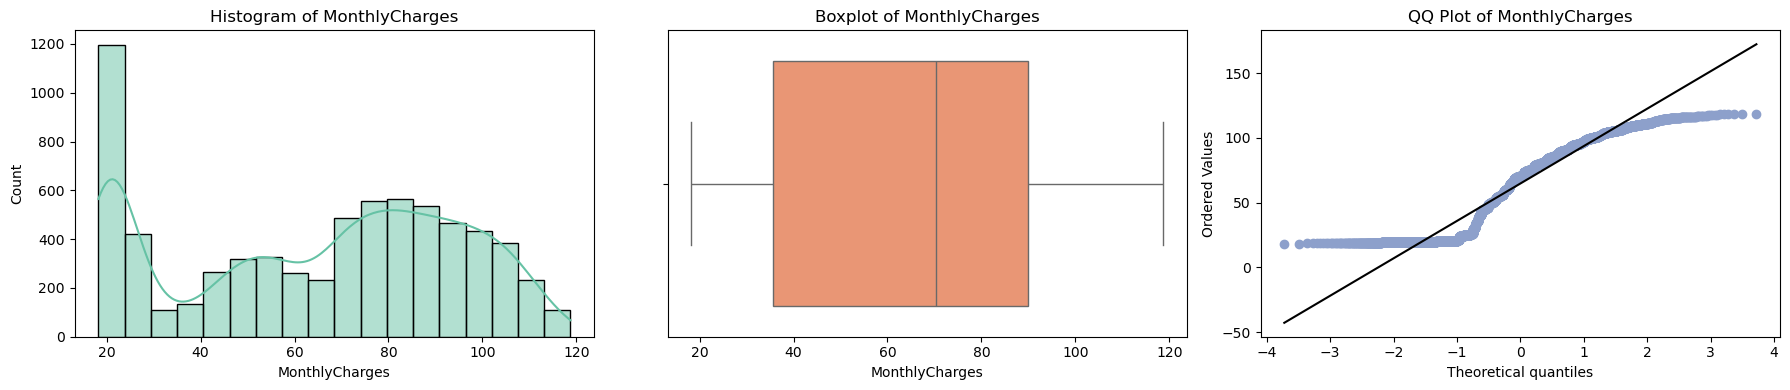

,Feature,t-statistic,p-value,Significant (p < 0.05)
0,MonthlyCharges,18.34,0.0,True


In [66]:
showQuantiDist("MonthlyCharges")

<div class="alert alert-info">
    The distribution of MonthlyCharges is multimodal and right-skewed, with non-normality confirmed by the QQ plot, and a significant t-test (p < 0.05) indicating that average monthly charges differ meaningfully between churned and non-churned customers
</div>

### TotalCharges

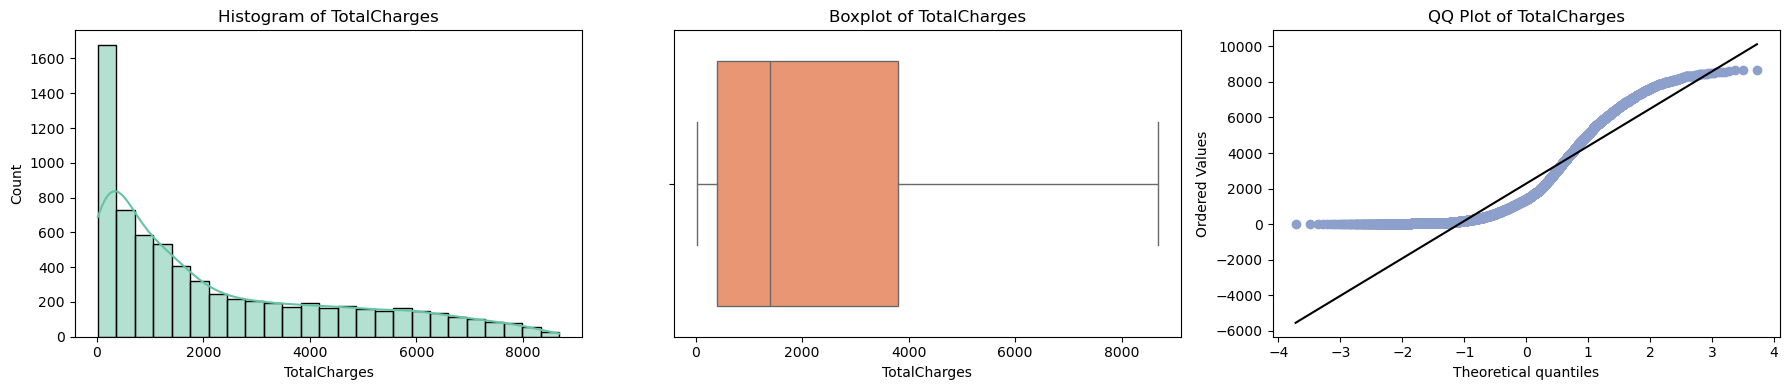

,Feature,t-statistic,p-value,Significant (p < 0.05)
0,TotalCharges,-18.8,0.0,True


In [69]:
showQuantiDist("TotalCharges")

<div class="alert alert-info">
    The TotalCharges variable is heavily right-skewed with a large concentration of low values, and based on the QQ plot and t-test result (p < 0.05), there is a significant difference in total charges between churned and retained customers — reinforcing that churners tend to leave before generating high revenue
</div>

### CLTV

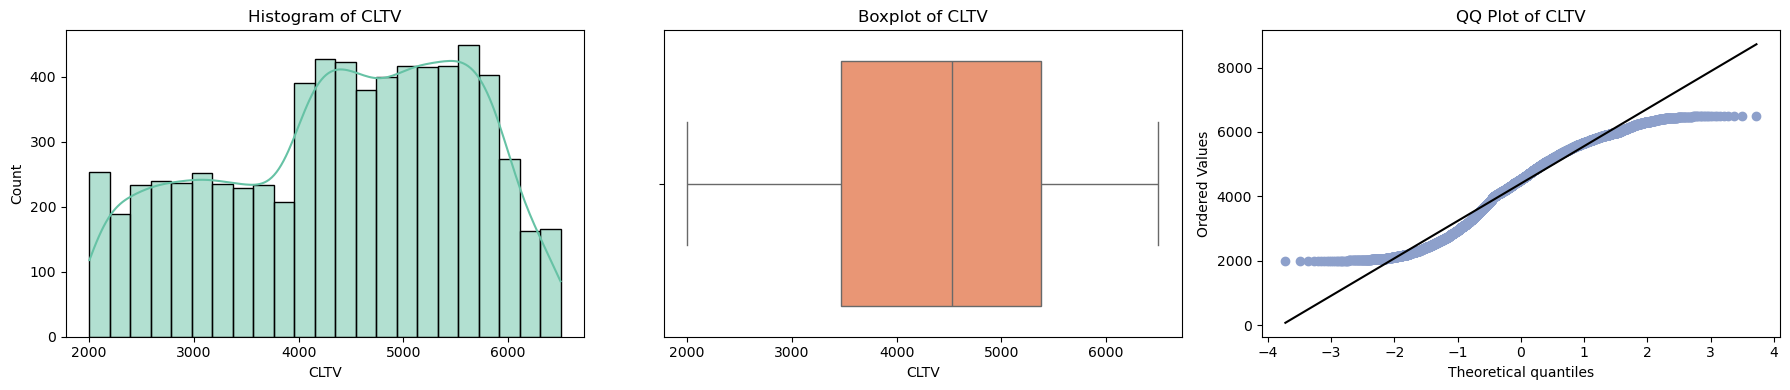

,Feature,t-statistic,p-value,Significant (p < 0.05)
0,CLTV,-10.75,0.0,True


In [72]:
showQuantiDist("CLTV")

<div class="alert alert-info">
    The CLTV (Customer Lifetime Value) distribution is slightly left-skewed, with a clear difference between churned and retained customers confirmed by the significant t-test (p < 0.05), indicating that churners typically contribute lower lifetime value to the business
</div>

### Data Correlation (Nominal and Ratio scale correlation)

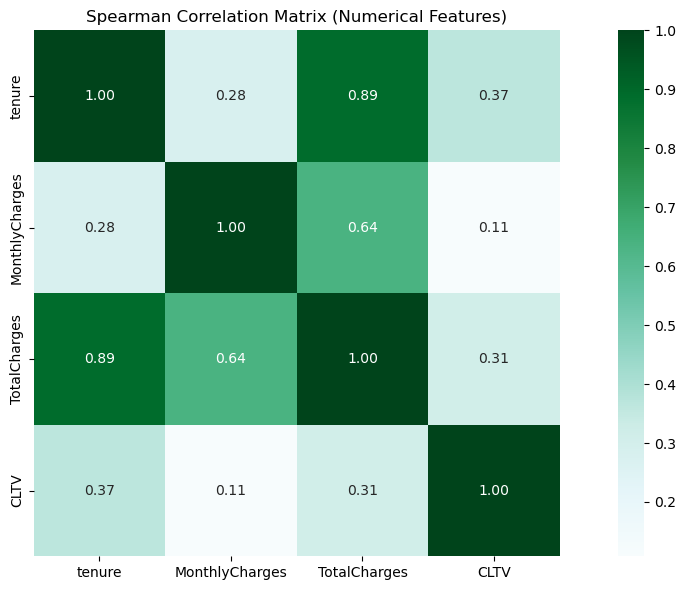

In [75]:
numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()

# Compute spearman correlation matrix
pearson_corr = df[numerical_features].corr(method="spearman")

# Plot the correlation heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(pearson_corr, annot=True, cmap="BuGn", fmt=".2f", square=True)
plt.title("Spearman Correlation Matrix (Numerical Features)")
plt.tight_layout()
plt.show()

<div class="alert alert-info">
    We are going to ignore the TotalCharges column, as the tenure variable already serves as a representative indicator of total charges over time
</div>

## Qualitative Data Distribution Analysis (Bar, Pie)

In [78]:
def showQualiDist(col):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Bar chart
    sns.countplot(
        data=df, x=col, order=df[col].value_counts().index, ax=axes[0], palette="Set2"
    )
    axes[0].set_title(f"Bar Chart of {col}")
    axes[0].set_ylabel("Count")
    axes[0].tick_params(axis="x", rotation=45)

    # Annotate counts
    for p in axes[0].patches:
        height = p.get_height()
        axes[0].annotate(
            f"{round(height/1000, 1)}K",
            (p.get_x() + p.get_width() / 2.0, height - 200),
            ha="center",
            va="bottom",
            fontsize=10,
        )

    # Pie chart
    pie_data = df[col].value_counts()
    axes[1].pie(
        pie_data,
        labels=pie_data.index,
        autopct="%1.1f%%",
        startangle=90,
        colors=sns.color_palette("Set2"),
    )
    axes[1].set_title(f"Pie Chart of {col}")
    axes[1].axis("equal")  # Equal aspect ratio ensures pie is a circle

    plt.tight_layout()
    plt.show()

    # Chi-Square Test
    chi2_table = pd.crosstab(df[col], df["Churn"])
    chi2, p, dof, ex = chi2_contingency(chi2_table)

    chi_result = {
        "Feature": col,
        "Chi-square": round(chi2, 2),
        "p-value": round(p, 4),
        "Significant (p < 0.05)": p < 0.05,
    }
    display(pd.DataFrame([chi_result]))

### gender

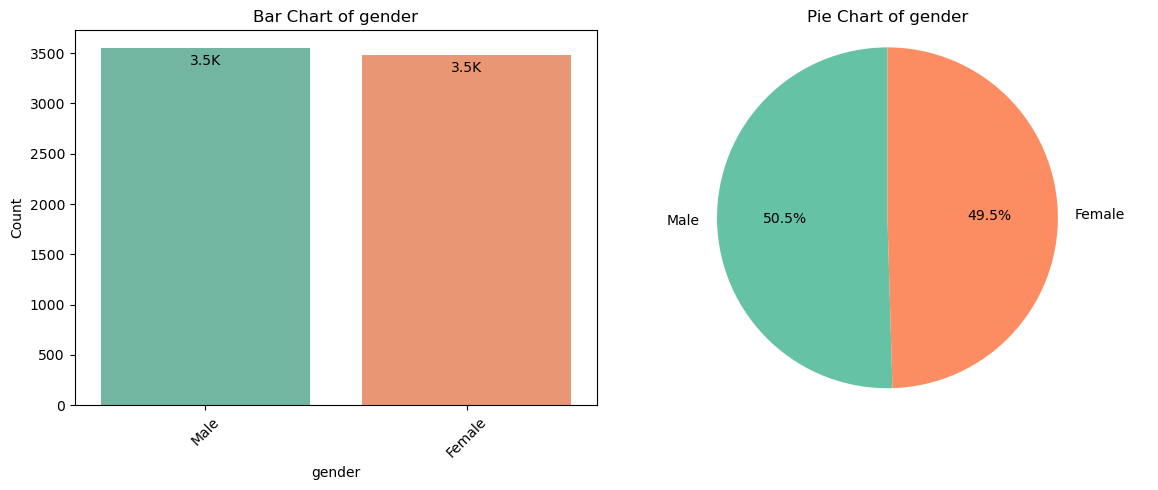

,Feature,Chi-square,p-value,Significant (p < 0.05)
0,gender,0.48,0.4905,False


In [80]:
showQualiDist("gender")

<div class="alert alert-info">
    Gender has no significant impact on churn behavior, as indicated by the nearly equal distribution (Male 50.5%, Female 49.5%) and a non-significant p-value of 0.4905.
</div>

### Partner

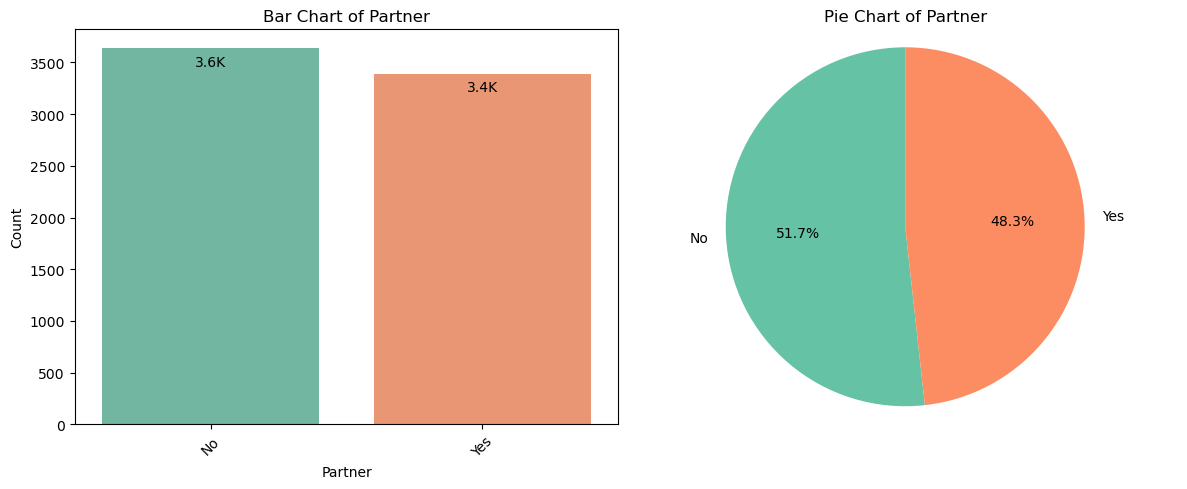

,Feature,Chi-square,p-value,Significant (p < 0.05)
0,Partner,157.5,0.0,True


In [83]:
showQualiDist("Partner")

<div class="alert alert-info">
    Having a partner shows a significant relationship with churn behavior (p-value = 0.0), where customers without partners (51.7%) are more likely to churn than those with partners (48.3%)
</div>

### AgeGroup

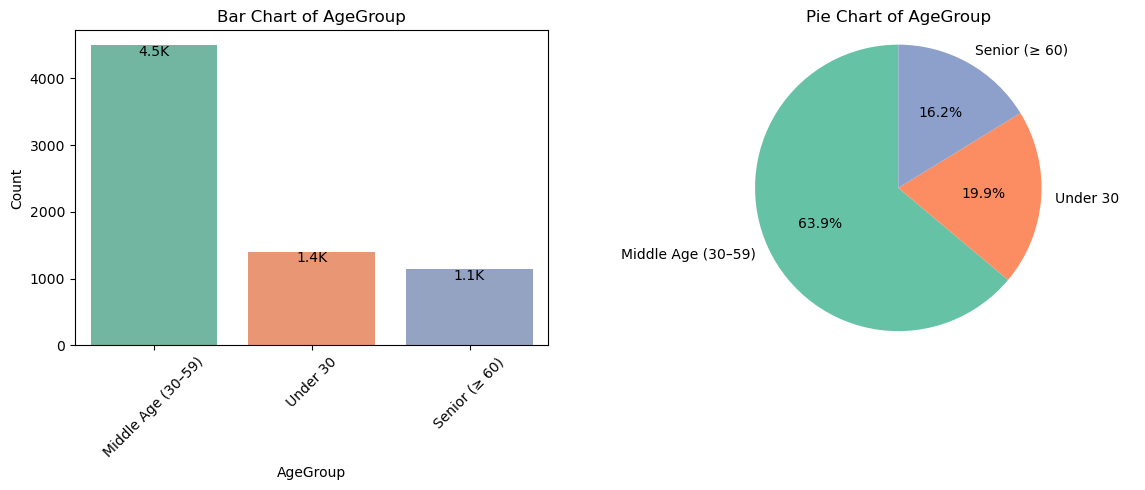

,Feature,Chi-square,p-value,Significant (p < 0.05)
0,AgeGroup,162.71,0.0,True


In [86]:
showQualiDist("AgeGroup")

<div class="alert alert-info">
    Age group significantly influences churn behavior (p-value = 0.0), with the majority of customers being middle-aged (30–59, 63.9%), while younger customers under 30 (19.9%) and seniors (16.2%) represent smaller proportions
</div>

### PhoneService

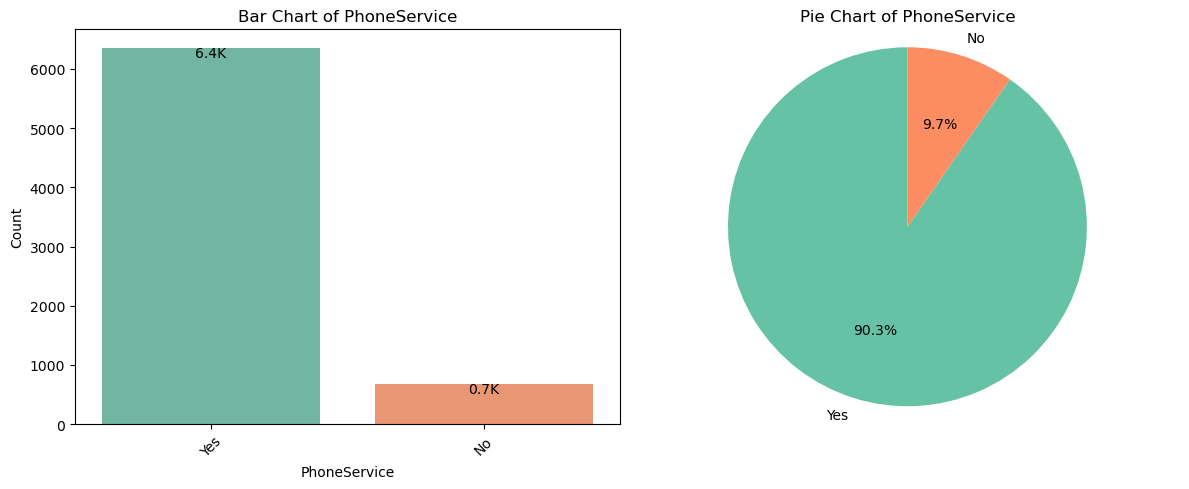

,Feature,Chi-square,p-value,Significant (p < 0.05)
0,PhoneService,0.87,0.3499,False


In [89]:
showQualiDist("PhoneService")

<div class="alert alert-info">
    Phone service subscription is very high among customers (90.3%), but with a p-value of 0.35, there is no statistically significant association between having phone service and churn behavior
</div>

### MultipleLines

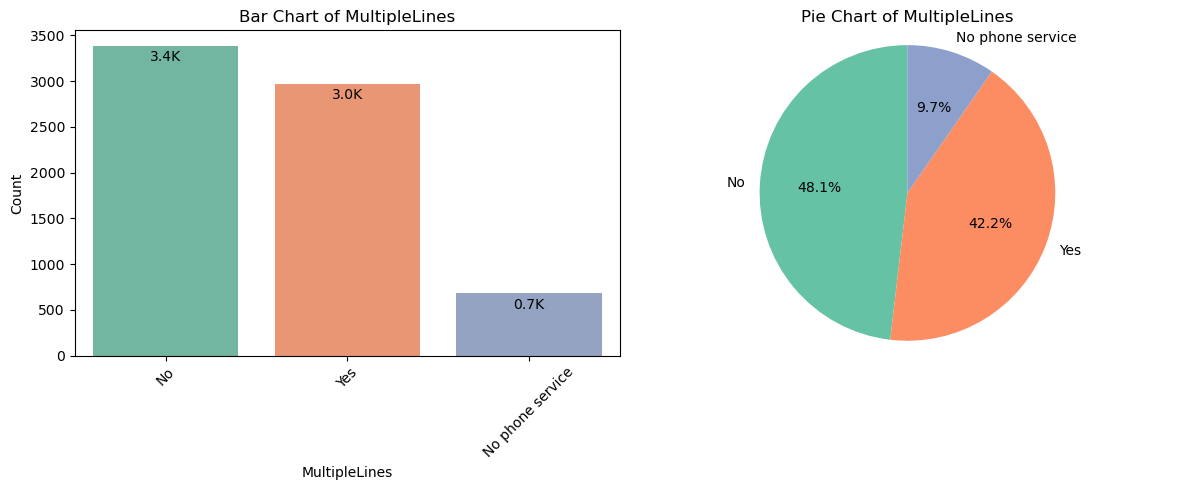

,Feature,Chi-square,p-value,Significant (p < 0.05)
0,MultipleLines,11.27,0.0036,True


In [92]:
showQualiDist("MultipleLines")

<div class="alert alert-info">
    Customers are fairly split between having and not having multiple lines, and the statistically significant p-value (0.0036) indicates that having multiple lines is associated with customer churn behavior
</div>

### InternetService

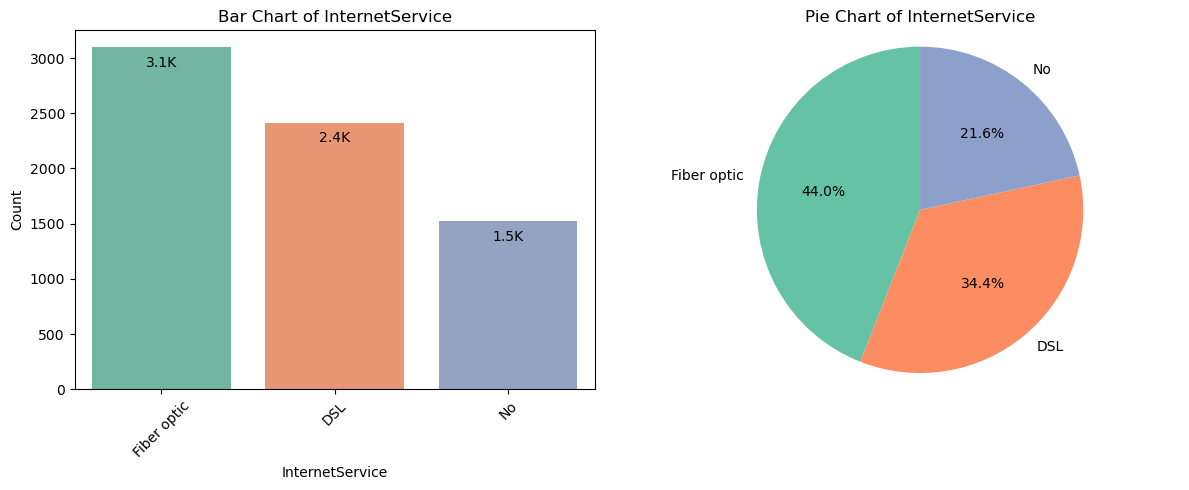

,Feature,Chi-square,p-value,Significant (p < 0.05)
0,InternetService,728.7,0.0,True


In [95]:
showQualiDist("InternetService")

<div class="alert alert-info">
    The distribution shows that fiber optic is the most commonly used internet service, and the highly significant p-value (0.0) suggests that the type of internet service is strongly associated with customer churn
</div>

### OnlineSecurity

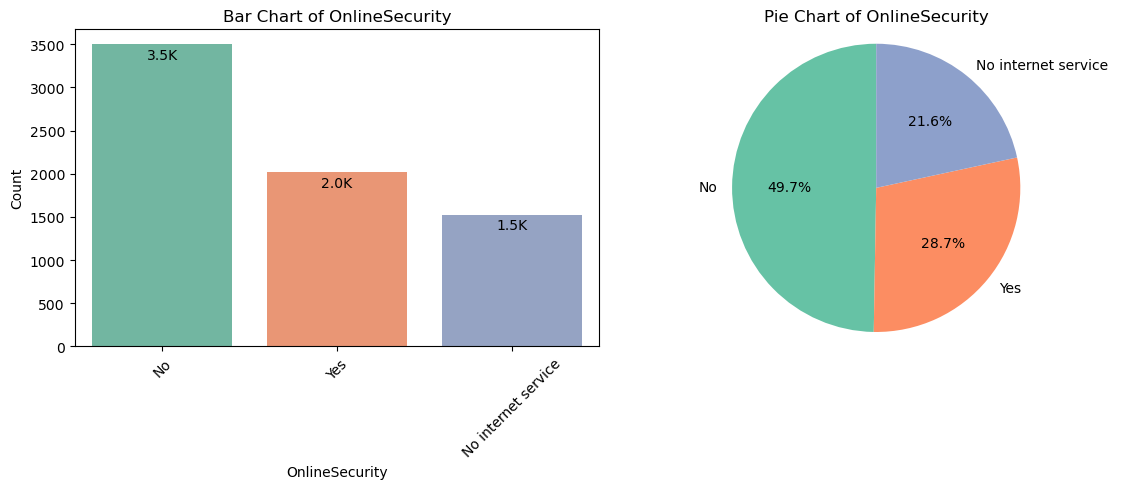

,Feature,Chi-square,p-value,Significant (p < 0.05)
0,OnlineSecurity,846.68,0.0,True


In [98]:
showQualiDist("OnlineSecurity")

<div class="alert alert-info">
    The distribution shows that a larger proportion of customers do not use online backup services, and the highly significant p-value (0.0) indicates a strong association between online backup availability and customer churn
</div>

### OnlineBackup

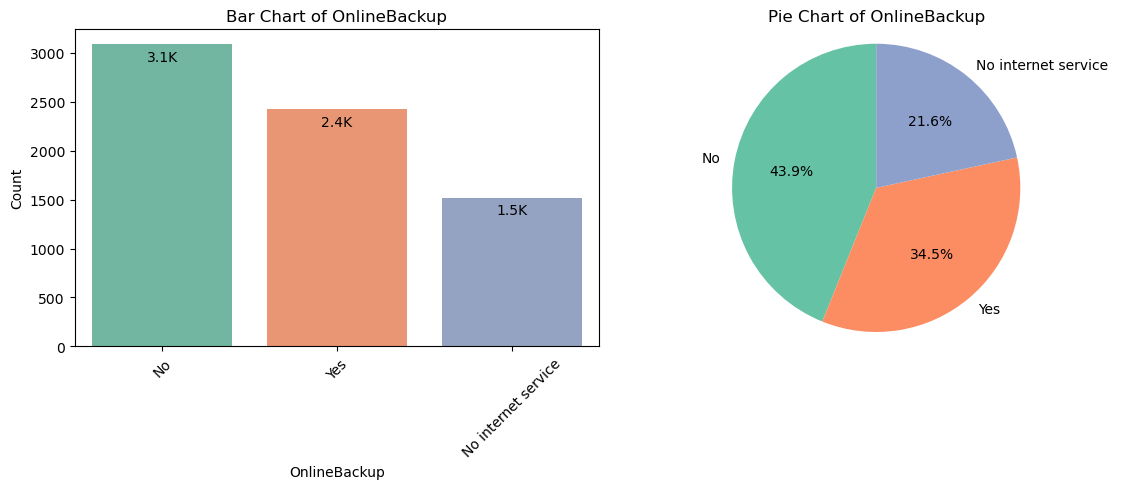

,Feature,Chi-square,p-value,Significant (p < 0.05)
0,OnlineBackup,599.18,0.0,True


In [101]:
showQualiDist("OnlineBackup")

<div class="alert alert-info">
    The distribution shows that a larger proportion of customers do not use online backup services, and the highly significant p-value (0.0) indicates a strong association between online backup availability and customer churn
</div>

### DeviceProtection

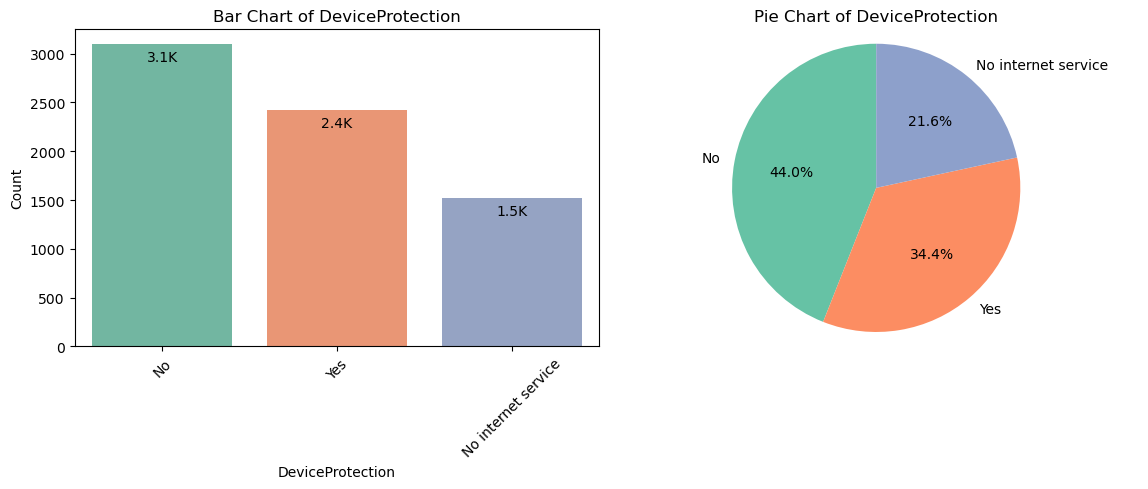

,Feature,Chi-square,p-value,Significant (p < 0.05)
0,DeviceProtection,555.88,0.0,True


In [104]:
showQualiDist("DeviceProtection")

<div class="alert alert-info">
    A larger portion of customers do not subscribe to device protection services, and the p-value of 0.0 indicates a statistically significant relationship between device protection and customer churn
</div>

### TechSupport

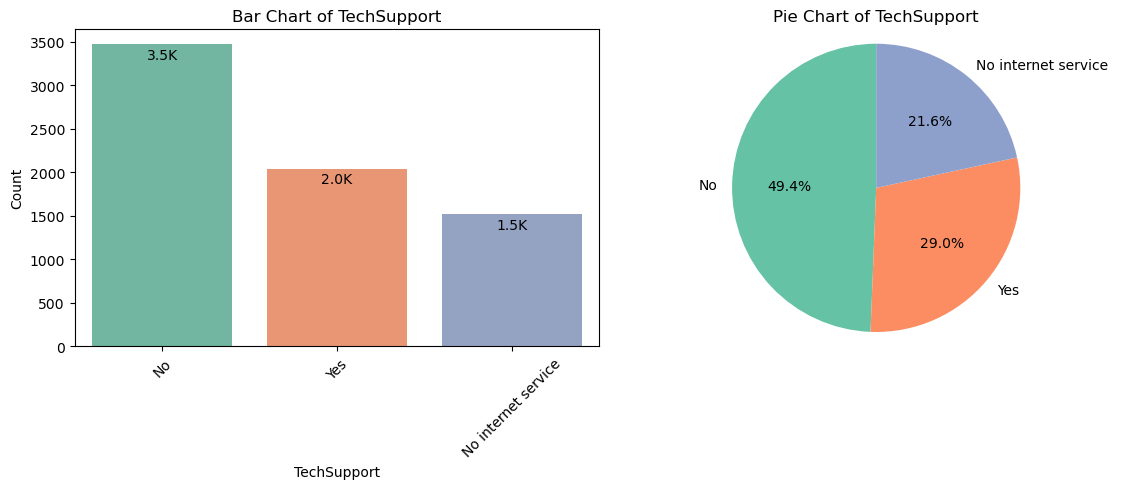

,Feature,Chi-square,p-value,Significant (p < 0.05)
0,TechSupport,824.93,0.0,True


In [107]:
showQualiDist("TechSupport")

<div class="alert alert-info">
    Most customers do not use tech support services, and the low p-value (0.0) suggests a statistically significant association between tech support usage and customer churn
</div>

### StreamingTV

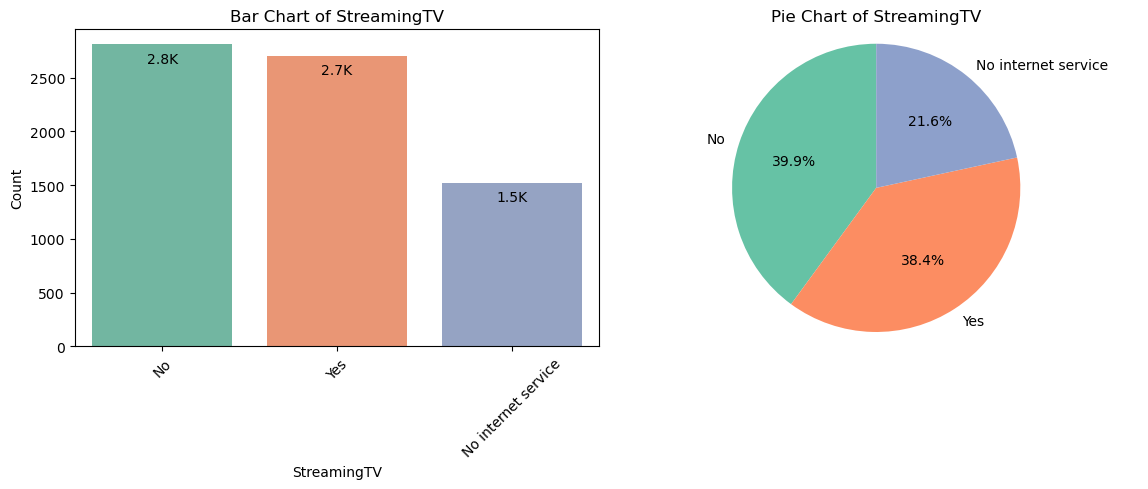

,Feature,Chi-square,p-value,Significant (p < 0.05)
0,StreamingTV,372.46,0.0,True


In [110]:
showQualiDist("StreamingTV")

<div class="alert alert-info">
    Customers are almost evenly split between having and not having StreamingTV, but the low p-value (0.0) indicates that StreamingTV usage is significantly associated with customer churn
</div>

### StreamingMovies

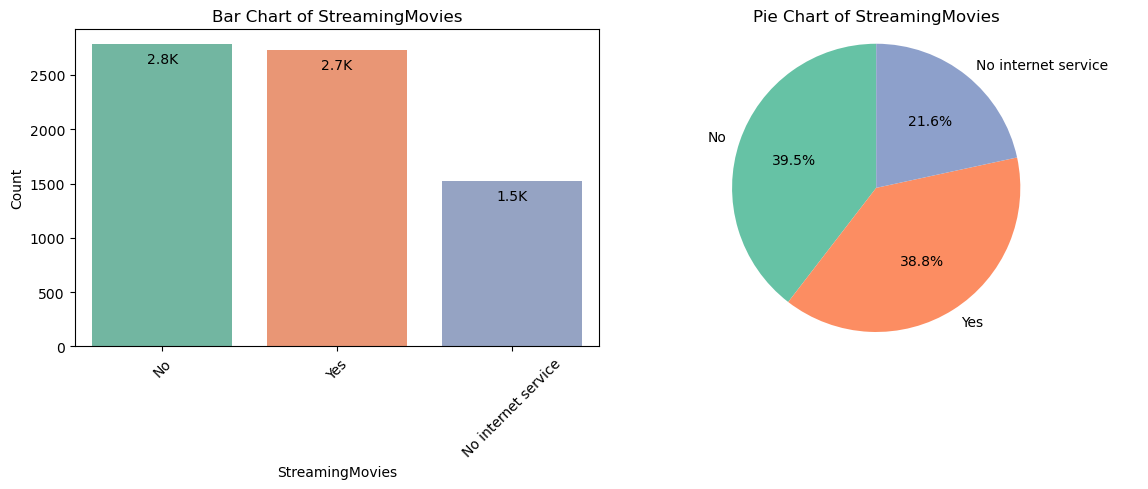

,Feature,Chi-square,p-value,Significant (p < 0.05)
0,StreamingMovies,374.27,0.0,True


In [113]:
showQualiDist("StreamingMovies")

<div class="alert alert-info">
    Customers are nearly evenly divided between using and not using StreamingMovies, and the significant p-value (0.0) indicates a strong association with customer churn behavior
</div>

### Contract

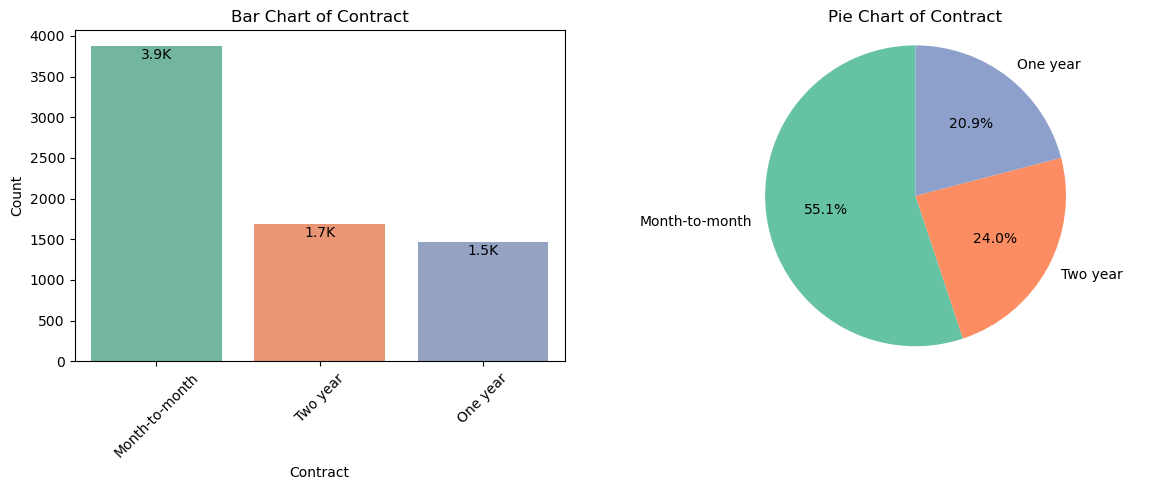

,Feature,Chi-square,p-value,Significant (p < 0.05)
0,Contract,1179.55,0.0,True


In [116]:
showQualiDist("Contract")

<div class="alert alert-info">
    Most customers are on month-to-month contracts (55.1%), and the highly significant p-value (0.0) indicates that contract type strongly influences customer churn
</div>

### PaperlessBilling

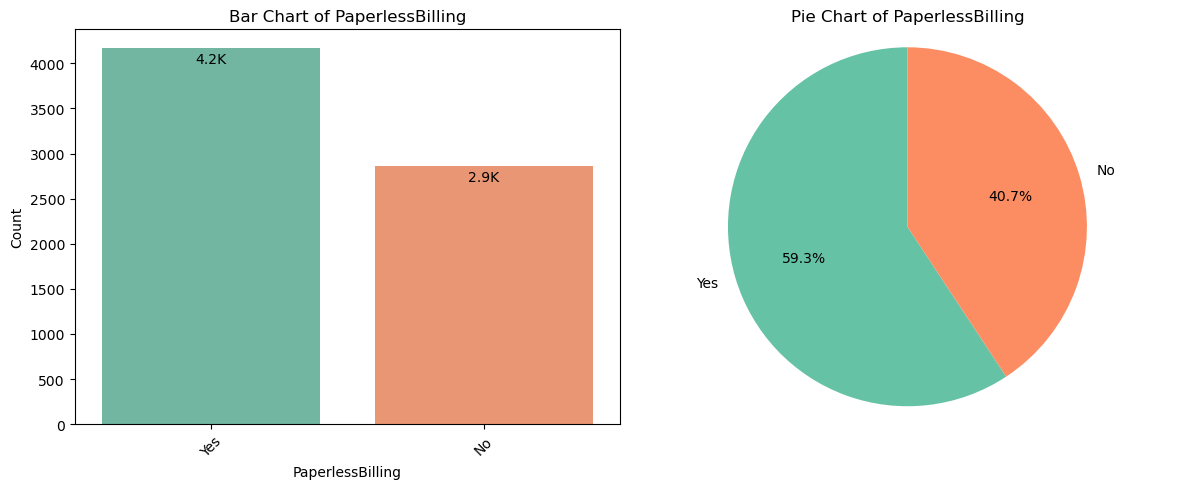

,Feature,Chi-square,p-value,Significant (p < 0.05)
0,PaperlessBilling,256.87,0.0,True


In [119]:
showQualiDist("PaperlessBilling")

<div class="alert alert-info">
    A majority of customers use paperless billing (59.3%), and the significant p-value (0.0) suggests that paperless billing is meaningfully associated with customer churn behavior
</div>

### PaymentMethod

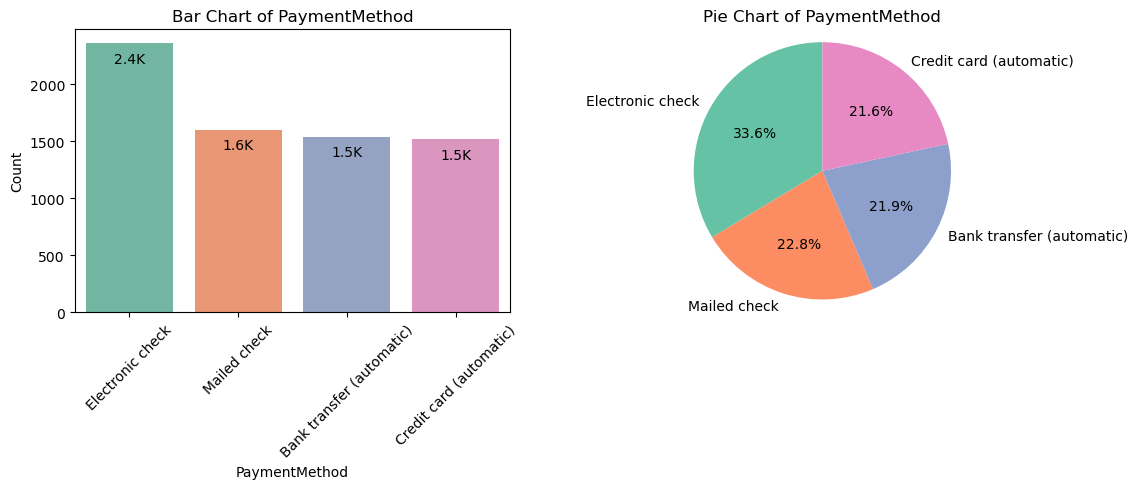

,Feature,Chi-square,p-value,Significant (p < 0.05)
0,PaymentMethod,645.43,0.0,True


In [122]:
showQualiDist("PaymentMethod")

<div class="alert alert-info">
    Electronic check is the most commonly used payment method (33.6%), and the low p-value (0.0) confirms that payment method is significantly associated with customer churn behavior
</div>

### Churn

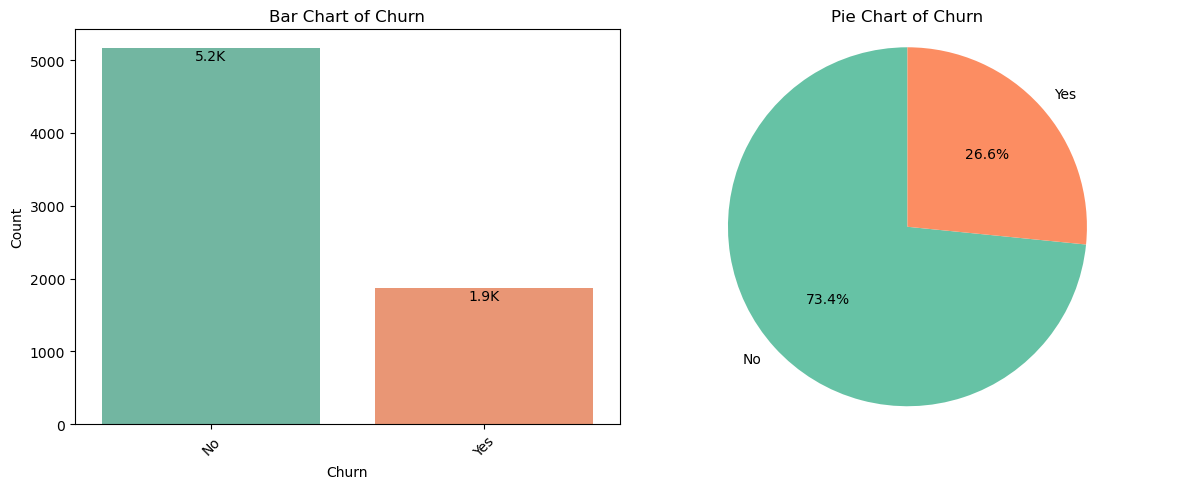

,Feature,Chi-square,p-value,Significant (p < 0.05)
0,Churn,7026.88,0.0,True


In [125]:
showQualiDist("Churn")
# "YES" di highlight di explode

<div class="alert alert-info">
    A total of 26.6% of customers have churned, while the remaining 73.4% have stayed, and the chi-square test confirms a statistically significant association in churn distribution (p-value = 0.0)
</div>

### Satisfaction Score

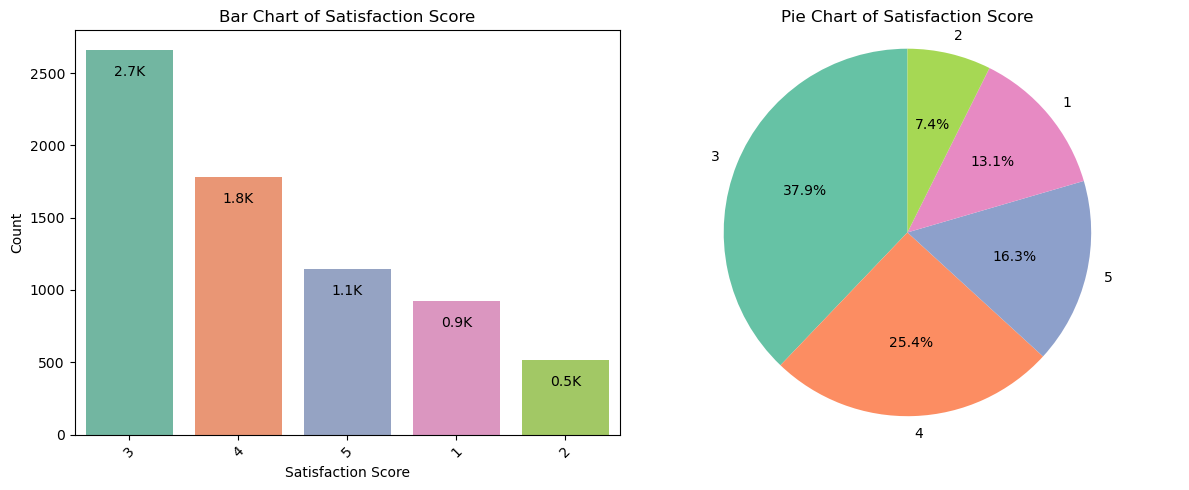

,Feature,Chi-square,p-value,Significant (p < 0.05)
0,Satisfaction Score,5187.9,0.0,True


In [128]:
showQualiDist("Satisfaction Score")

<div class="alert alert-info">
    The Satisfaction Score is a statistically significant feature (p < 0.05), where churned customers generally have much lower scores, making it a strong predictor for churn classification
</div>

## Filter Used Features

In [131]:
df = df[
    [
        "customerID",
        "Partner",
        "MultipleLines",
        "InternetService",
        "OnlineSecurity",
        "OnlineBackup",
        "DeviceProtection",
        "TechSupport",
        "StreamingTV",
        "StreamingMovies",
        "Contract",
        "PaperlessBilling",
        "PaymentMethod",
        "tenure",
        "MonthlyCharges",
        "CLTV",
        "Satisfaction Score",
        "Churn",
        "AgeGroup",
    ]
]

In [132]:
df.to_csv("Dataset/df_clean.csv", index=False)

<div class="alert alert-info">
    Filter the features to be used for modeling
</div>

---

# Methodology (Data Analytics)
---

## Significant Quantitative Feature with Churn

In [137]:
def showQuantiChurn(col, unit=""):
    fig, axes = plt.subplots(figsize=(8, 4))
    sns.boxplot(data=df, y="Churn", x=col, palette="Set2")
    plt.title(f"{col.capitalize()} by Churn")
    if unit != "":
        plt.xlabel(f"{col.capitalize()} ({unit})")
    else:
        plt.xlabel(col.capitalize())
    plt.ylabel("Churn")
    plt.tight_layout()
    plt.show()

### Tenure

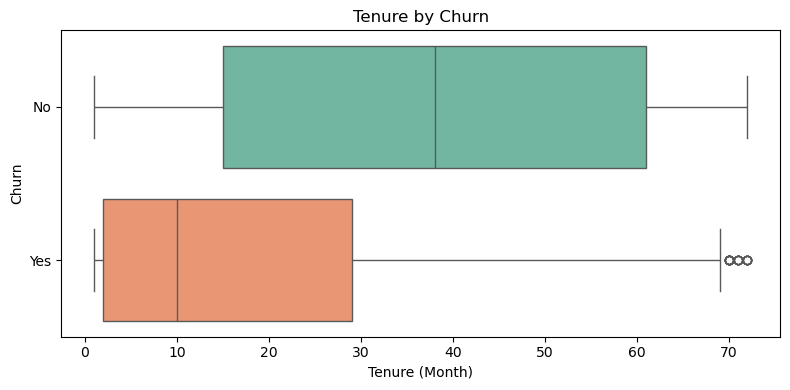

In [139]:
showQuantiChurn("tenure", "Month")

<div class="alert alert-info">Churned customers are concentrated in the early tenure (6–15 months). Longer-term customers are more stable. This suggests the need to focus on new customer engagement to reduce churn.</div>

### Monthly Charges

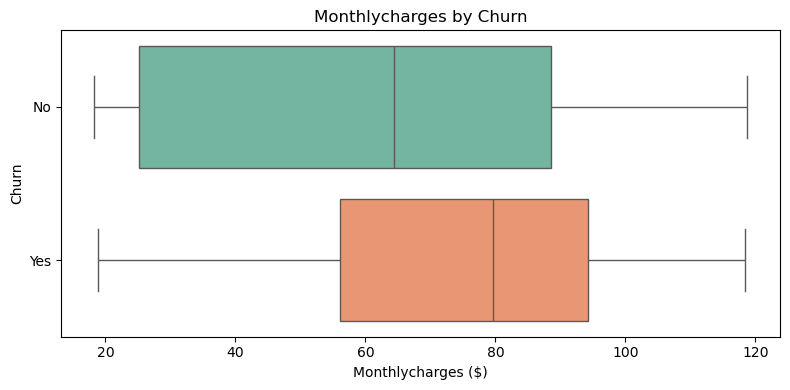

In [142]:
showQuantiChurn("MonthlyCharges", "$")

<div class="alert alert-info">Customers with higher monthly charges are more likely to churn. This suggests dissatisfaction with value or affordability and hints that pricing restructuring or bundling could reduce churn.</div>

### CLTV

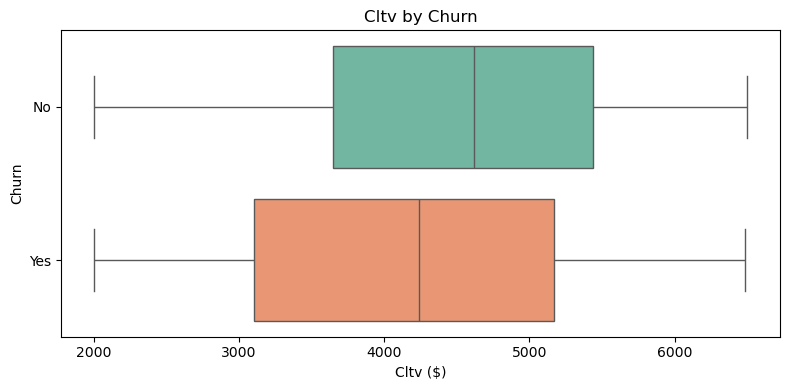

In [145]:
showQuantiChurn("CLTV", "$")

<div class="alert alert-info">
    Customers who did not churn generally have a higher Customer Lifetime Value (CLTV) compared to those who churned, indicating that long-term customers contribute more value, while some churned customers still exhibit high CLTV, highlighting potential missed retention opportunities
</div>

## Significant Qualitative Feature with Churn

In [148]:
def showQualiChurn(col, unit=""):
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    # Vertical Bar Chart
    churn_counts = df.groupby([col, "Churn"]).size().unstack(fill_value=0)
    churn_counts.plot(
        kind="bar", stacked=False, ax=axes[0], color=sns.color_palette("Set2")
    )

    for i, category in enumerate(churn_counts.index):
        for j, churn_value in enumerate(["No", "Yes"]):
            if churn_value in churn_counts.columns:
                count = churn_counts.loc[category, churn_value]
                axes[0].text(
                    i + (j - 0.5) * 0.2,
                    count,
                    f"{round(count/1000, 1)}K",
                    ha="center",
                    va="bottom",
                )

    axes[0].set_title(f"Churn Count by {col}")
    axes[0].set_xlabel(col)
    axes[0].set_ylabel("Count")
    axes[0].legend(title="Churn")

    # Horizontal Bar Chart
    churn_rate = (
        churn_counts["Yes"] / (churn_counts["Yes"] + churn_counts["No"])
    ) * 100
    churn_rate = churn_rate.sort_values(ascending=False)

    churn_counts.index = churn_counts.index.astype(str)
    churn_rate.index = churn_rate.index.astype(str)

    sns.barplot(x=churn_rate.values, y=churn_rate.index, ax=axes[1], color="coral")
    for i, (val, name) in enumerate(zip(churn_rate.values, churn_rate.index)):
        axes[1].text(val + 0.5, i, f"{val:.1f}%", va="center")

    overall_churn = df["Churn"].value_counts(normalize=True)["Yes"] * 100
    axes[1].axvline(
        overall_churn,
        color="red",
        linestyle="--",
        linewidth=1.5,
        label=f"Overall Churn: {overall_churn:.1f}%",
    )
    axes[1].legend(loc="lower right")
    axes[1].set_title(f"Churn Rate per Category (Yes / Total in Category)")
    axes[1].set_xlabel("Churn Rate (%)")
    axes[1].set_ylabel(col)

    plt.tight_layout()
    plt.show()

### Partner

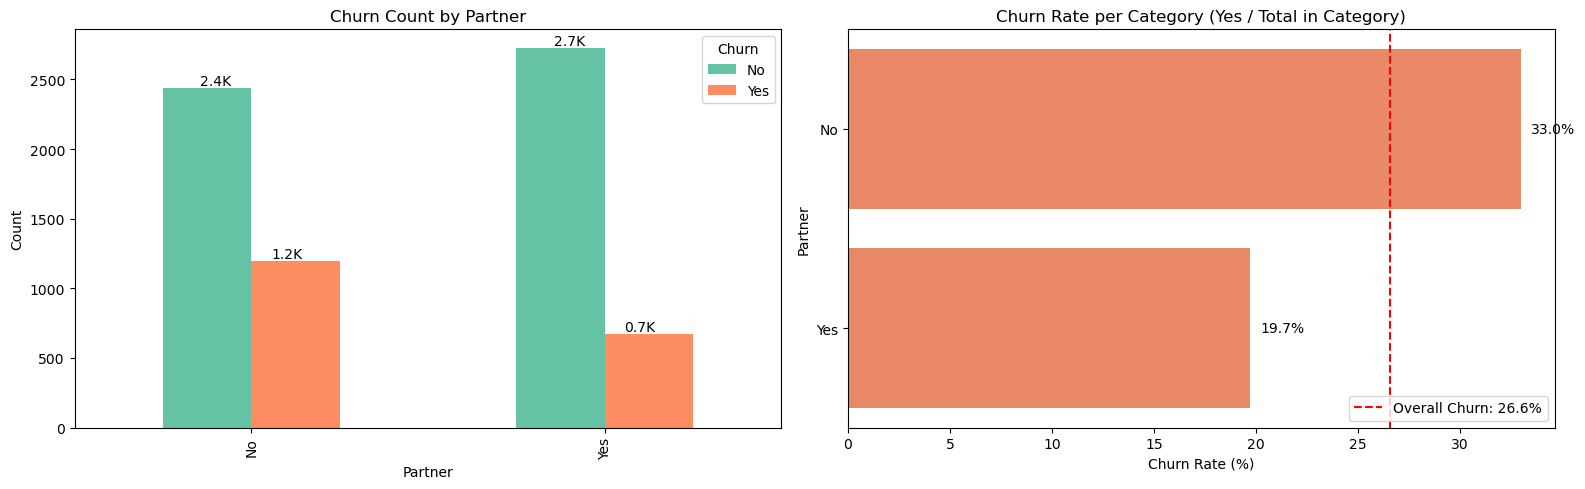

In [150]:
showQualiChurn("Partner")

<div class="alert alert-info">
    Customers without a partner have a higher churn rate (33.2%) than those with a partner (19.6%), indicating that being in a partnership may contribute to customer retention
</div>

### AgeGroup

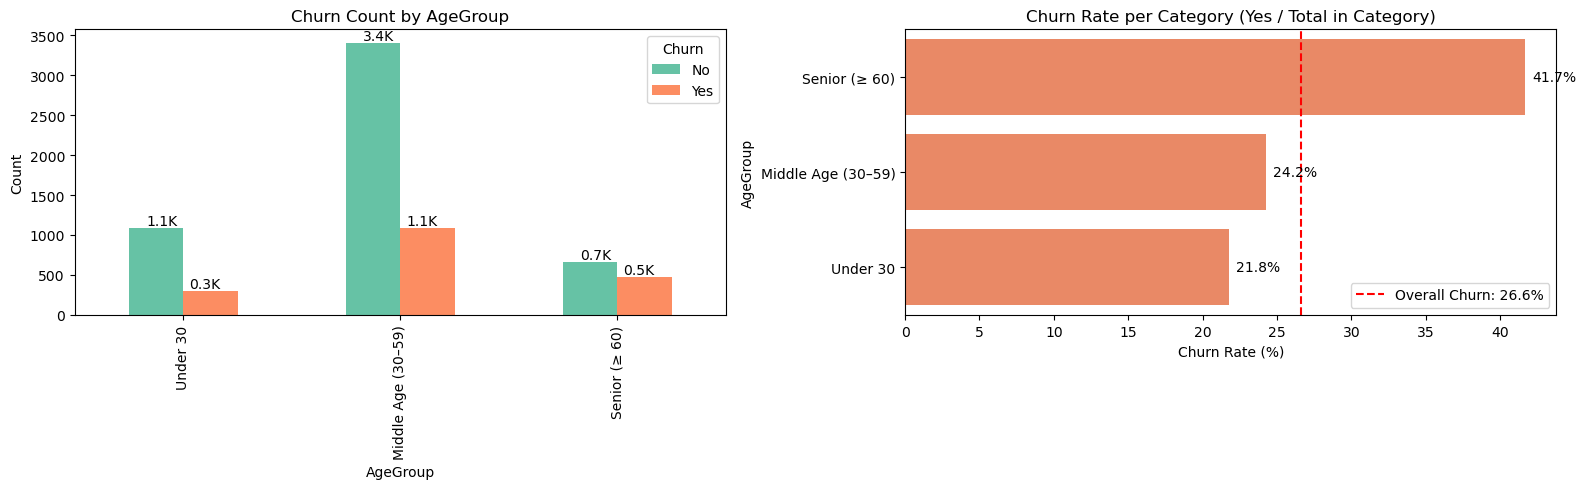

In [153]:
showQualiChurn("AgeGroup")

<div class="alert alert-info">
    Senior customers (≥ 60) have the highest churn rate at 41.8%, significantly above the overall churn rate of 26.6%, indicating they are the most likely age group to leave the service
</div>

### MultipleLines

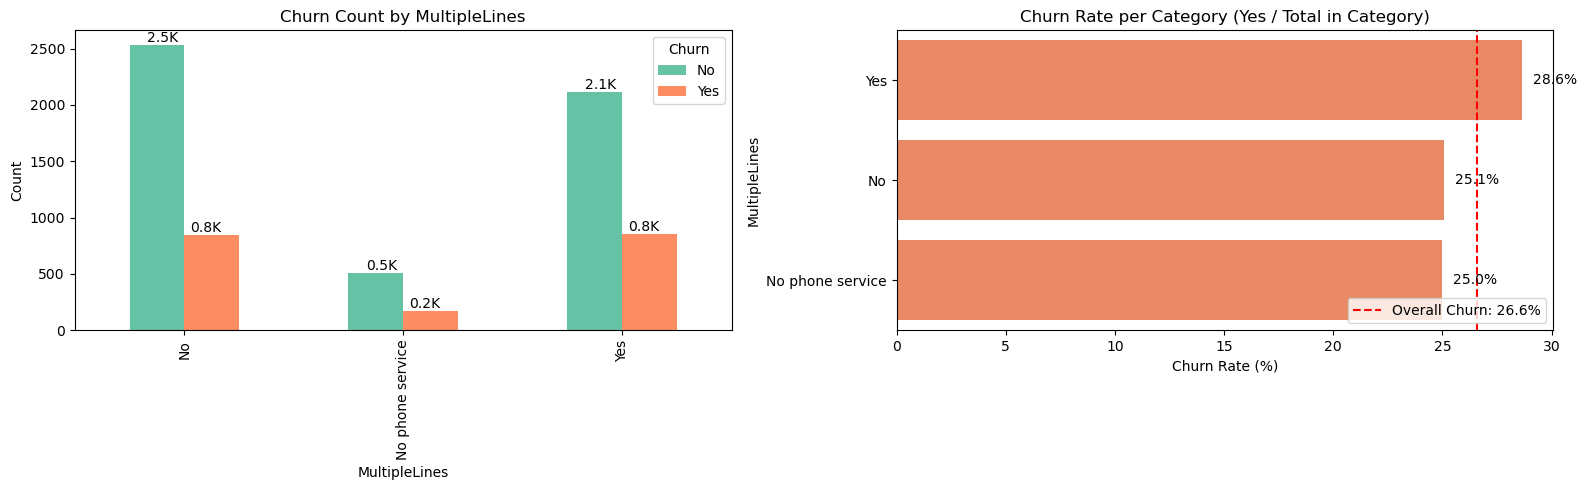

In [156]:
showQualiChurn("MultipleLines")

<div class="alert alert-info">
    Customers with multiple lines have the highest churn rate at 28.8%, slightly above the overall churn rate of 26.6%, suggesting that managing multiple lines may contribute to customer dissatisfaction
</div>

### InternetService

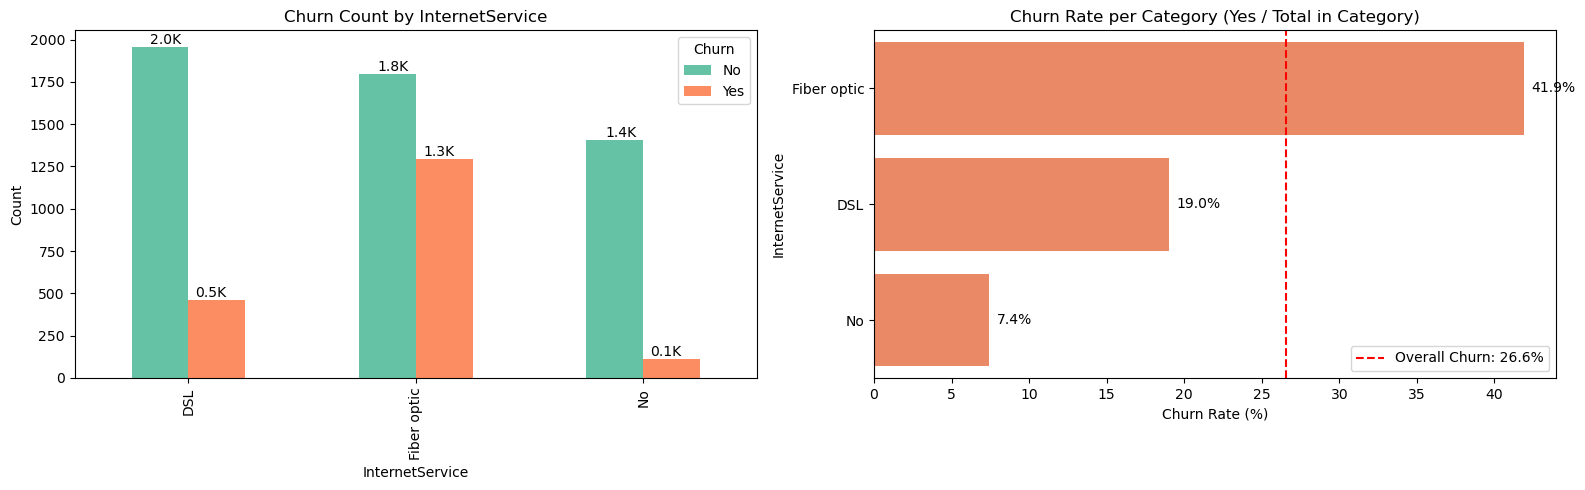

In [159]:
showQualiChurn("InternetService")

<div class="alert alert-info">
    Customers using Fiber optic internet have the highest churn rate at 41.8%, well above the overall churn rate of 26.6%, indicating a strong association between fiber optic usage and customer attrition
</div>

### OnlineSecurity

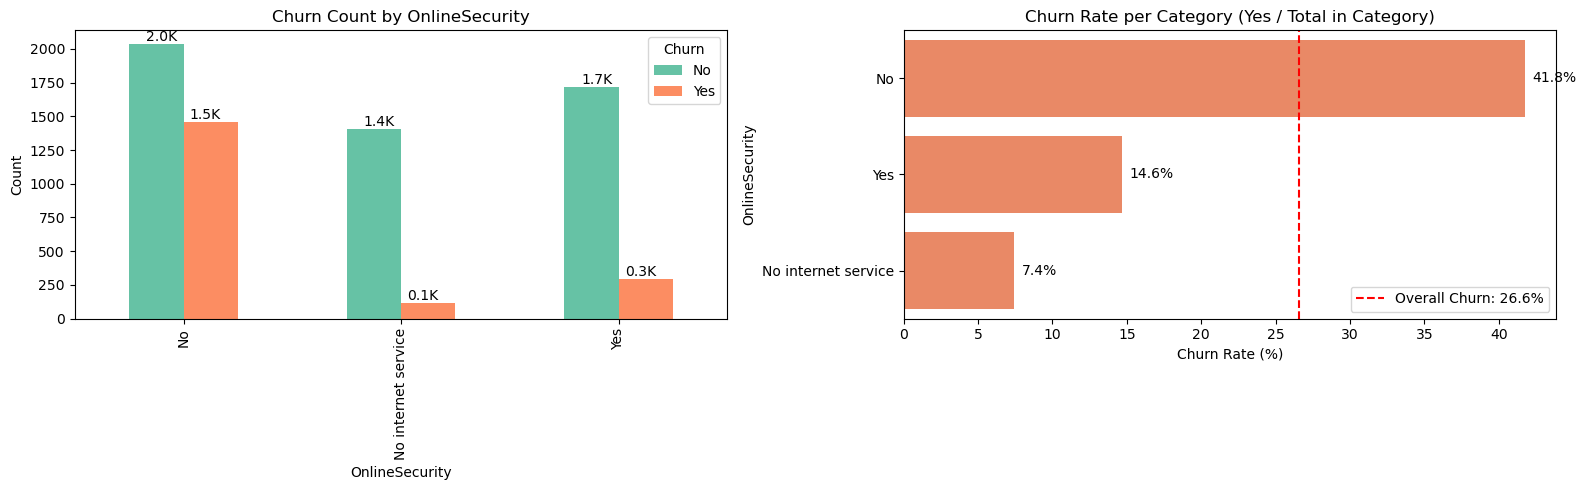

In [162]:
showQualiChurn("OnlineSecurity")

<div class="alert alert-info">
    Customers without Online Security have the highest churn rate at 41.9%, significantly exceeding the overall churn rate of 26.6%, suggesting that the absence of this service may strongly contribute to customer attrition
</div>

### OnlineBackup

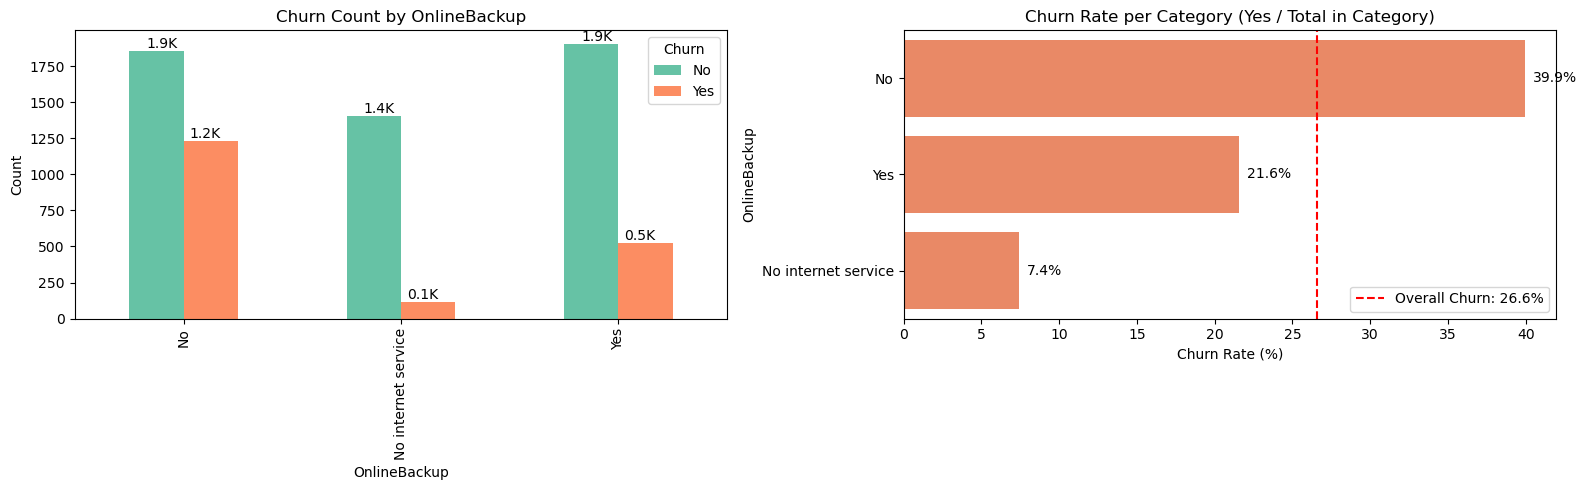

In [165]:
showQualiChurn("OnlineBackup")

<div class="alert alert-info">
    Customers without Online Backup have a churn rate of 40.2%, well above the overall churn rate of 26.6%, indicating that the absence of this service may significantly contribute to customer churn
</div>

### DeviceProtection

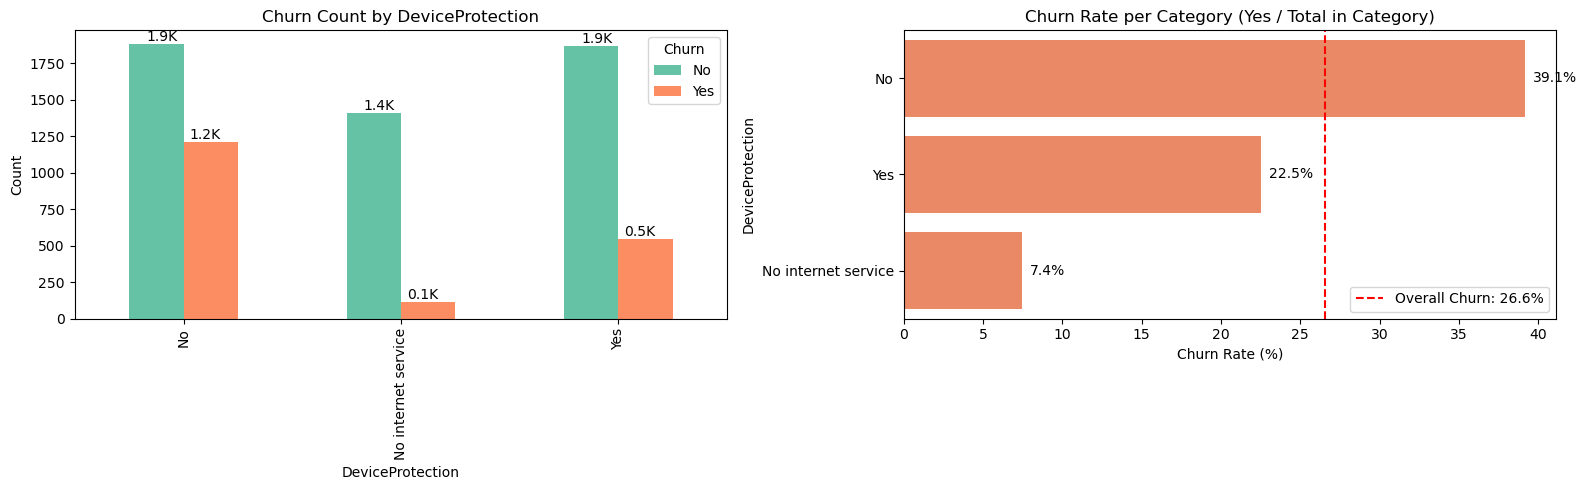

In [168]:
showQualiChurn("DeviceProtection")

<div class="alert alert-info">
    Customers without Device Protection show a significantly higher churn rate of 39.0%, compared to 22.7% for those with protection, suggesting that offering or promoting this service may help reduce churn
</div>

### TechSupport

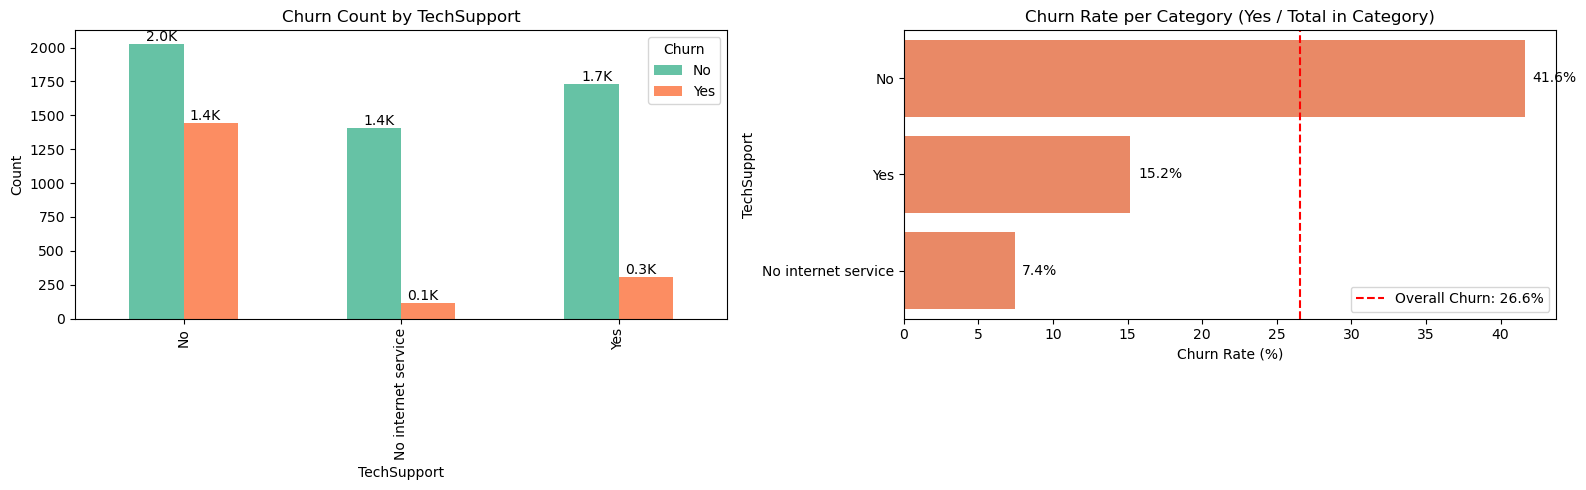

In [171]:
showQualiChurn("TechSupport")

<div class="alert alert-info">
    Customers without Tech Support experience the highest churn rate at 41.8%, while those with Tech Support churn significantly less at 15.3%, indicating that providing technical assistance may help improve customer retention
</div>

### StreamingTV

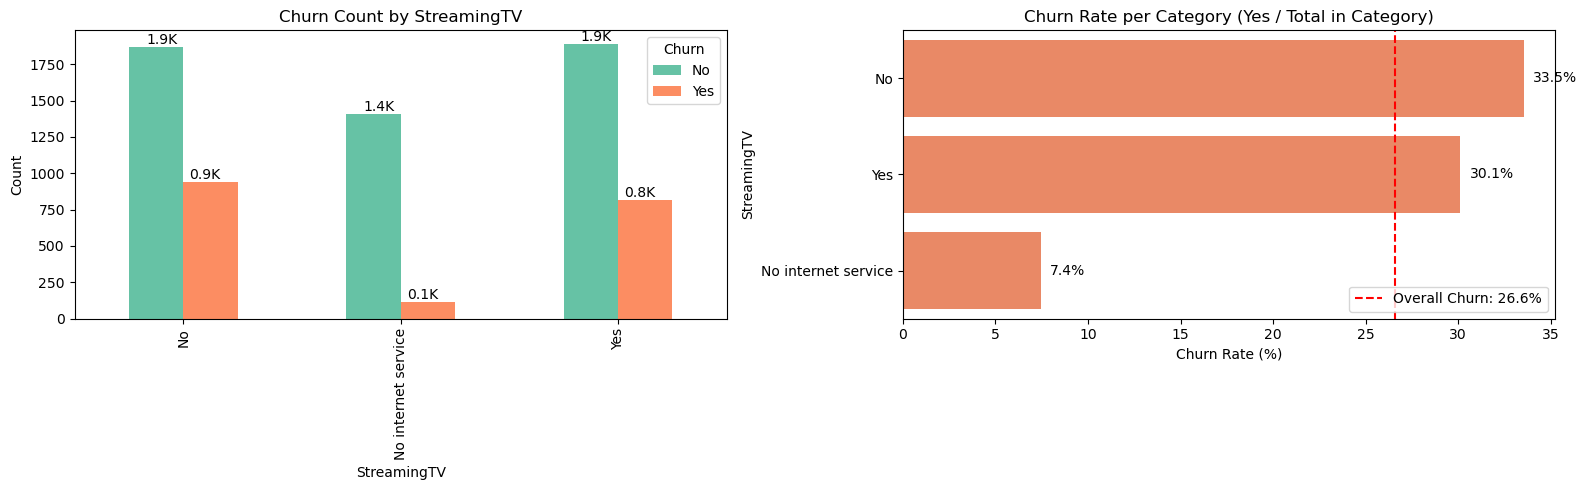

In [174]:
showQualiChurn("StreamingTV")

<div class="alert alert-info">
    Customers who do not subscribe to StreamingTV have a slightly higher churn rate (33.3%) than those who do (30.6%), suggesting that the absence of this service may slightly contribute to customer attrition
</div>

### StreamingMovies

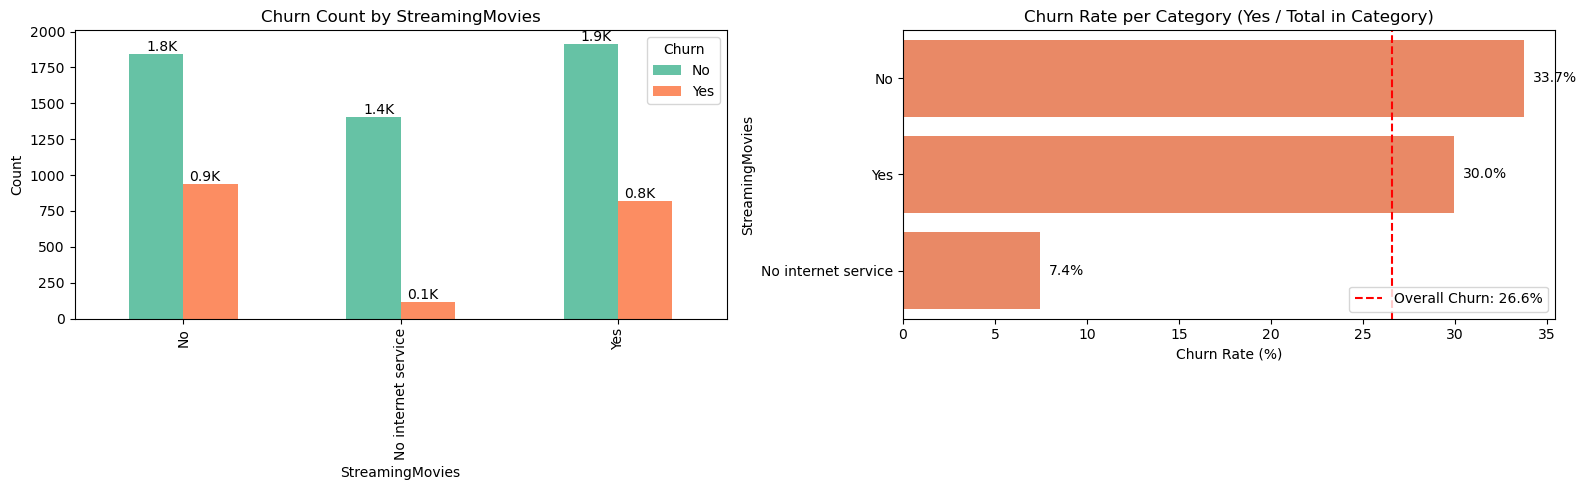

In [177]:
showQualiChurn("StreamingMovies")

<div class="alert alert-info">
    Customers who do not subscribe to StreamingMovies have a higher churn rate (33.4%) compared to those who do (30.2%), indicating that lack of access to streaming movie services may be associated with increased customer attrition
</div>

### Contract

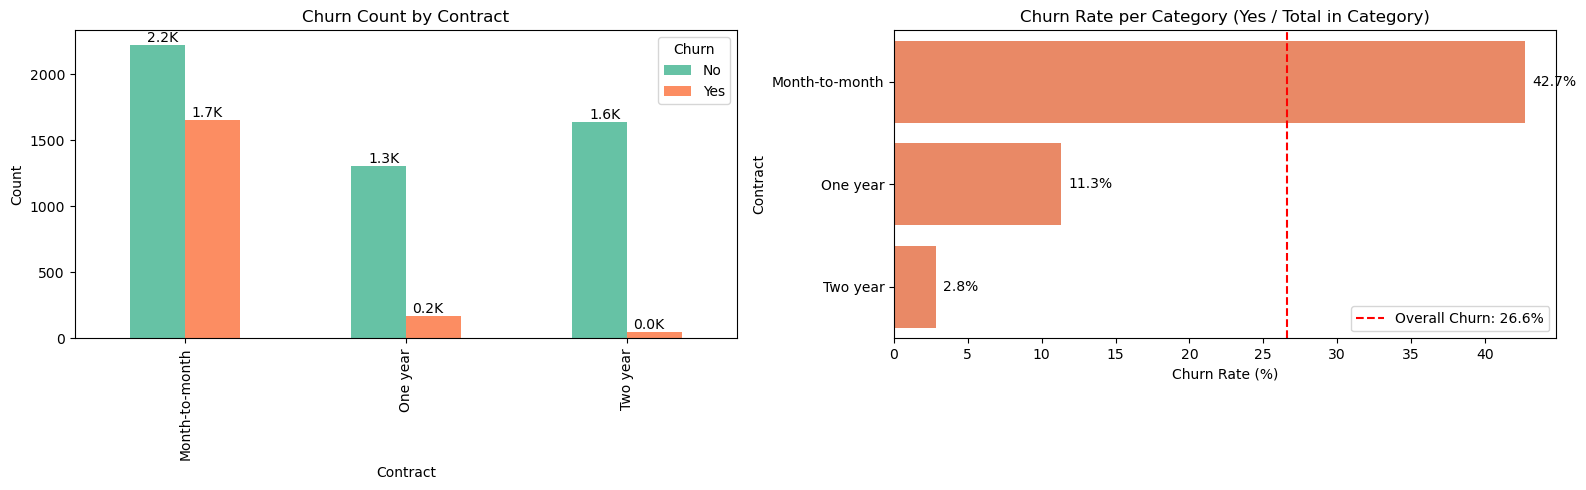

In [180]:
showQualiChurn("Contract")

<div class="alert alert-info">
    Customers on month-to-month contracts exhibit a significantly higher churn rate (43.1%), whereas those on longer-term contracts especially two-year agreements (2.9%) are far less likely to churn, indicating stronger retention with longer commitments
</div>

### PaperlessBilling

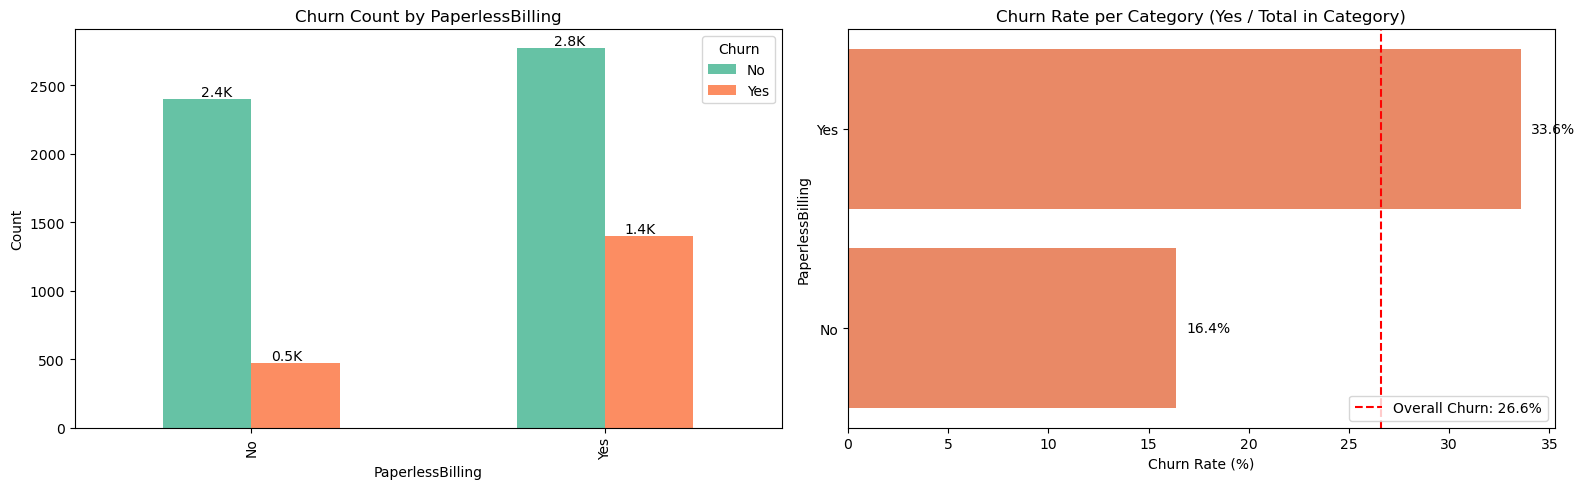

In [183]:
showQualiChurn("PaperlessBilling")

<div class="alert alert-info">
    Customers who opt for paperless billing have a churn rate of 33.4%, which is notably higher than the 16.5% churn rate among those who receive paper bills, suggesting that paperless users may be less engaged or more prone to switching services
</div>

### PaymentMethod

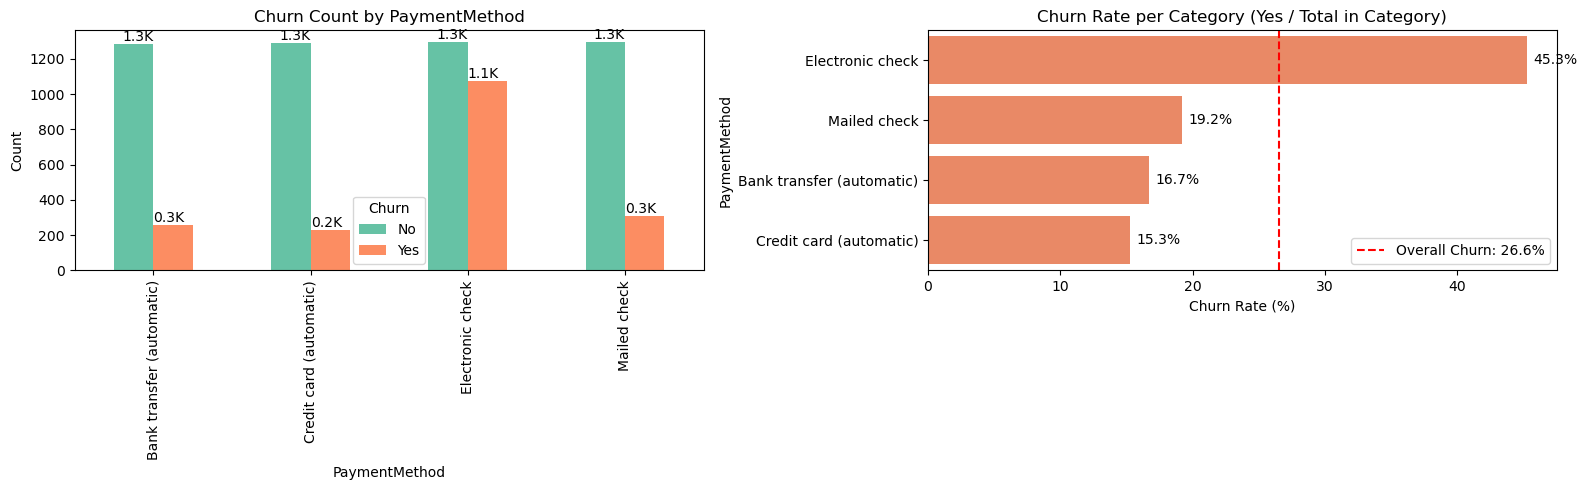

In [186]:
showQualiChurn("PaymentMethod")

<div class="alert alert-info">
    Customers using electronic checks as their payment method have the highest churn rate at 45.4%, significantly exceeding the overall churn rate of 26.6%. In contrast, churn rates are notably lower for automatic payment methods such as credit cards (15.4%) and bank transfers (16.0%), indicating that customers with automated payments are more likely to remain loyal
</div>

### Satisfaction Score

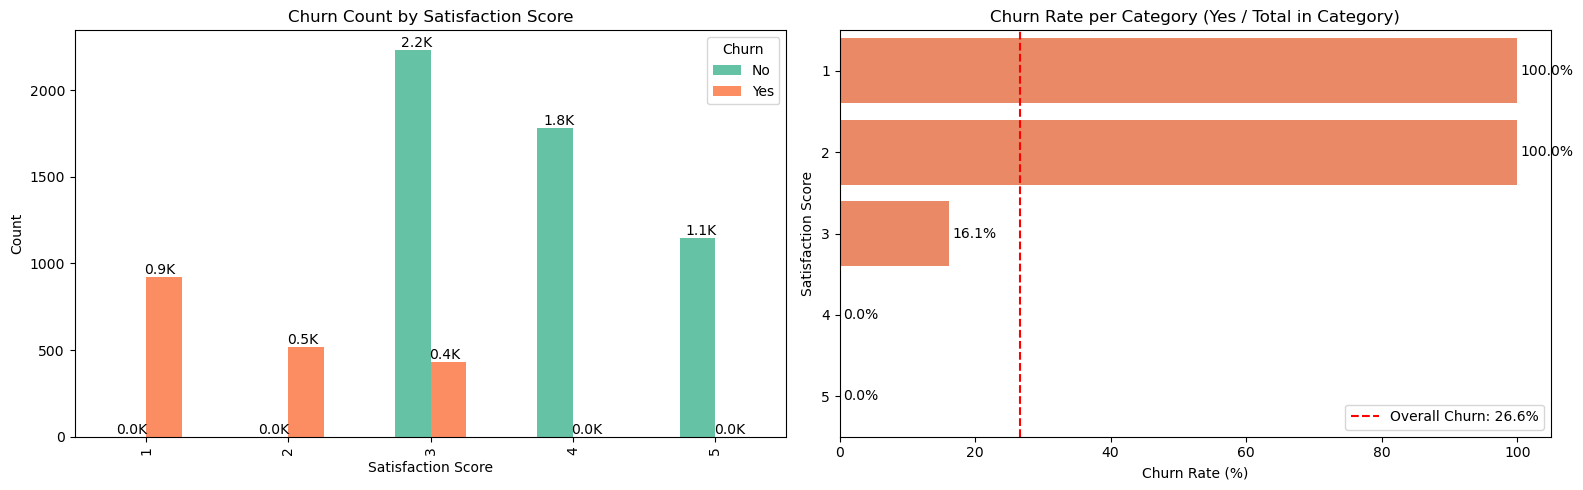

In [189]:
showQualiChurn("Satisfaction Score")

<div class="alert alert-info">
    Customers with low satisfaction scores (1 and 2) have a 100% churn rate, while those with higher scores (4 and 5) show no churn at all, indicating that satisfaction score is a strong predictor of churn behavior as satisfaction increases, churn likelihood drastically decreases
</div>

## Analysis Results

### TOP 3: Feature Importance Based on Statistic Score

| **Feature**      | **Type**    | **Test**   | **Statistic** | **No** | **Yes** | **No Internet Service** |
| ---------------- | ----------- | ---------- | ------------- | ------ | ------- | ----------------------- |
| OnlineSecurity   | Categorical | Chi-square | 846.68        | 41.8%  | 13.6%   | 7.4%                    |
| TechSupport      | Categorical | Chi-square | 824.93        | 41.6%  | 15.2%   | 7.4%                    |
| DeviceProtection | Categorical | Chi-square | 555.88        | 39.1%  | 22.5%   | 7.4%                    |

In [193]:
df_analytic = df[["OnlineSecurity", "TechSupport", "DeviceProtection", "Churn"]].copy()

<div class="alert alert-info">
    Create df_analytic to store the top 3 features with the highest statistic scores
</div>

In [195]:
df_analytic["RuleBased_Churn_Prediction"] = (
    (df_analytic["OnlineSecurity"] == "No")
    | (df_analytic["TechSupport"] == "No")
    | (df_analytic["DeviceProtection"] == "No")
).astype(int)

rule_based_churn_summary = (
    df_analytic["RuleBased_Churn_Prediction"]
    .value_counts()
    .rename(index={0: "Not Churned", 1: "Churned"})
    .reset_index()
)
rule_based_churn_summary.columns = ["Churn Prediction", "Customer Count"]
rule_based_churn_summary

,Churn Prediction,Customer Count
0,Churned,4801
1,Not Churned,2231


<div class="alert alert-success" role="alert">
    Using the rule-based method, we are able to predict that 4,801 customers are likely to churn from a total of 7,032
</div>

---

# Methodology (Machine Learning)
---

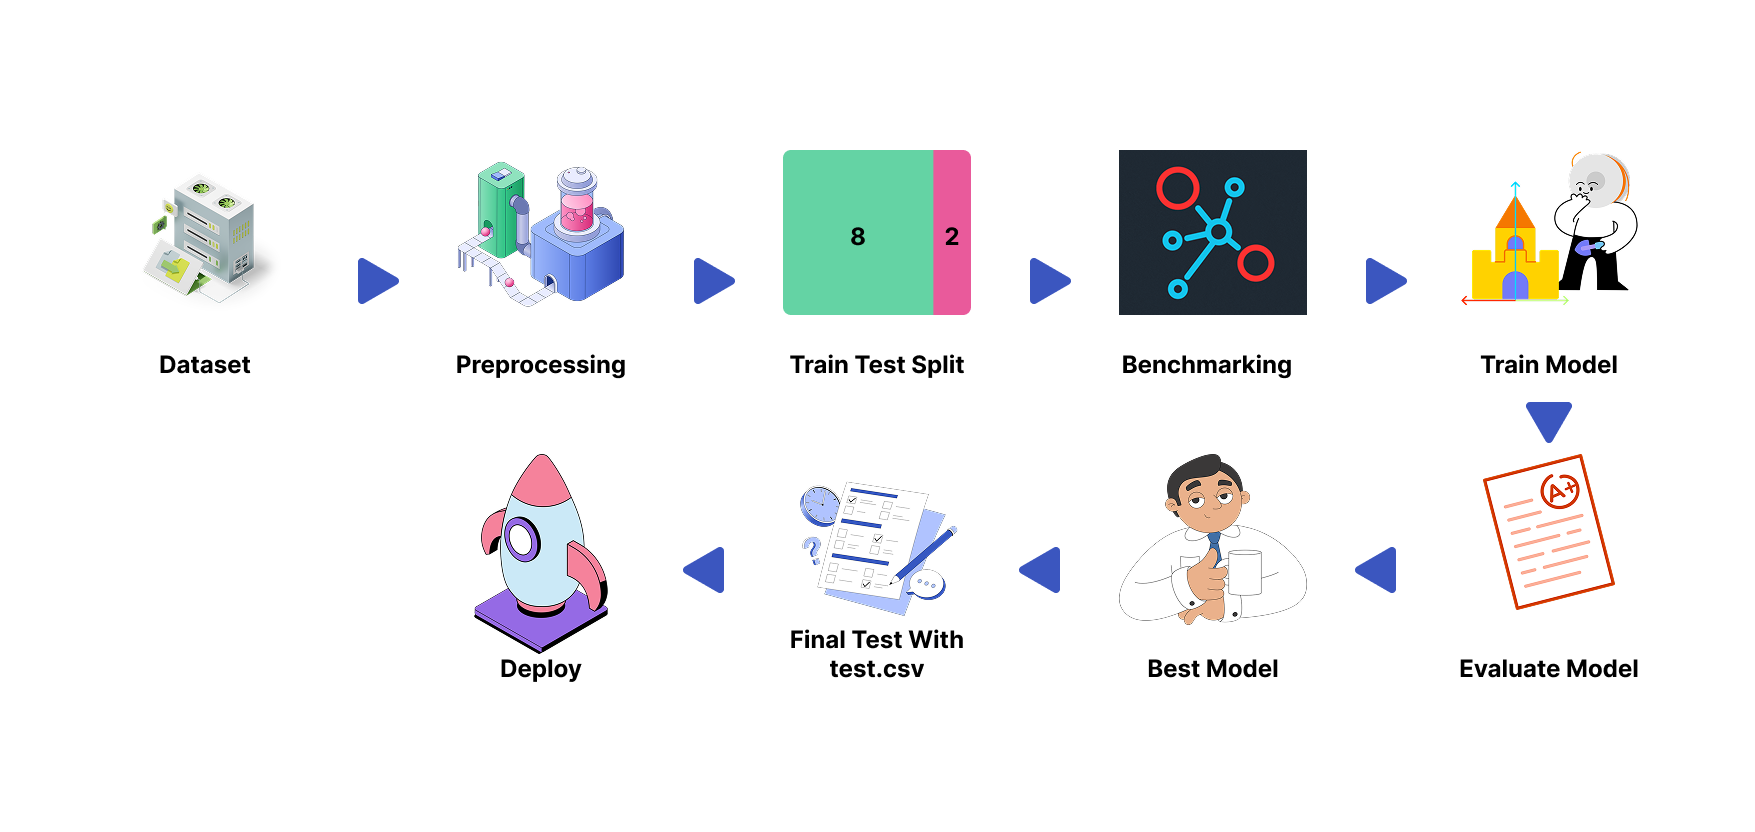

In [200]:
df["Churn"] = df["Churn"].map({"No": 0, "Yes": 1})

<div class="alert alert-success" role="alert">
    We convert the values in the Churn feature from 'No' to 0 and 'Yes' to 1 to prepare the data for model training
</div>

## Feature Selection

In [203]:
X = df.drop(columns=["customerID", "Churn"])
y = df["Churn"]

<div class="alert alert-warning" role="alert">
    We define the features (X) and target (y) for model training. We drop the customerID column because it does not provide meaningful information for learning patterns, and we drop the Churn column from X since it serves as our target variable (y)
</div>

## Data Splitting

In [206]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

<div class="alert alert-info" role="alert">
    We then split the data into training and testing sets, using 80% for training and 20% for testing
</div>

## Preprocessing

In [209]:
num_cols = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()

num_transformer = Pipeline(
    [("imputer", SimpleImputer(strategy="median")), ("scaler", RobustScaler())]
)

cat_transformer = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(drop="first", handle_unknown="ignore")),
    ]
)

preprocessor = ColumnTransformer(
    [("num", num_transformer, num_cols), ("cat", cat_transformer, cat_cols)],
    remainder="passthrough",
)
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', RobustScaler())]),
                                 ['tenure', 'MonthlyCharges', 'CLTV']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 ['Partner', 'MultipleLines', 'InternetService',
                                  'OnlineSecurity', 'OnlineBackup',
                                  'DeviceProtection', 'TechSupport',
                                  'StreamingTV', 'StreamingMovies', 'Contract',
                                  'PaperlessBilling', 'PaymentMethod',
                                  'Satisfaction Score', 'AgeGroup'])])

<div class="alert alert-info" role="alert">
    We include an imputer in the model pipeline to handle future datasets. For <b>numerical features</b>, we apply <b>RobustScaler</b>, and for <b>categorical features</b>, we use <b>OneHotEncoder</b>
</div>

## Modeling & Evaluation

In [212]:
models = {
    "Logistic Regression": LogisticRegression(),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(eval_metric="logloss", use_label_encoder=False),
    "LightGBM": lgb.LGBMClassifier(),
    "SVM": SVC(probability=True),
}

<div class="alert alert-info" role="alert">
    We proceed to benchmark the following models: Logistic Regression, K-Nearest Neighbors, Decision Tree, Random Forest, XGBoost, LightGBM, and Support Vector Machine (SVM)
</div>

### Model Benchmarking

In [215]:
# Setup CV strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

f2_scores = []
roc_aucs = []

# Cross-validated model evaluation
for name, model in models.items():
    pipe = Pipeline([("preprocess", preprocessor), ("model", model)])

    # Get cross-validated predictions (probabilities and labels)
    y_pred = cross_val_predict(pipe, X_train, y_train, cv=cv, method="predict")
    y_proba = cross_val_predict(pipe, X_train, y_train, cv=cv, method="predict_proba")[
        :, 1
    ]

    # Calculate evaluation metrics
    f2 = fbeta_score(y_train, y_pred, beta=2)
    roc = roc_auc_score(y_train, y_proba)

    f2_scores.append(f2)
    roc_aucs.append(roc)

# Compile results into a DataFrame
results_df = (
    pd.DataFrame(
        {
            "Model": list(models.keys()),
            "Mean F2 Score": sum(f2_scores) / len(f2_scores),
            "Mean ROC AUC": sum(roc_aucs) / len(roc_aucs),
        }
    )
    .set_index("Model")
    .sort_values(by="Mean F2 Score", ascending=False)
)

print("\nModel Benchmarking Results:")
display(results_df)

[LightGBM] [Info] Number of positive: 1196, number of negative: 3304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000221 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 640
[LightGBM] [Info] Number of data points in the train set: 4500, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265778 -> initscore=-1.016151
[LightGBM] [Info] Start training from score -1.016151
[LightGBM] [Info] Number of positive: 1196, number of negative: 3304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000111 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 640
[LightGBM] [Info] Number of data points in the train set: 4500, number of used features: 32
[LightGBM] [Info] [binary:

,Mean F2 Score,Mean ROC AUC
Model,,
Logistic Regression,0.865476,0.966284
KNN,0.865476,0.966284
Decision Tree,0.865476,0.966284
Random Forest,0.865476,0.966284
XGBoost,0.865476,0.966284
LightGBM,0.865476,0.966284
SVM,0.865476,0.966284


<div class="alert alert-success" role="alert">
    <b>Logistic Regression</b> had the highest F2 Score, indicating it's especially strong in minimizing false negatives (good for churn prediction where missing a churner is costly)
</div>

### Tuning Hyperparameter

In [218]:
# Logistic Regression pipeline
logreg_pipe = Pipeline(
    [("preprocess", preprocessor), ("model", LogisticRegression(max_iter=1000))]
)

# Hyperparameter grid
param_grid_logreg = {
    "model__penalty": ["l1", "l2"],
    "model__C": [0.01, 0.1, 1, 10],
    "model__solver": ["liblinear", "saga"],
}

grid_search = GridSearchCV(
    estimator=logreg_pipe,
    param_grid=param_grid_logreg,
    scoring="f1",
    cv=5,
    verbose=1,
    n_jobs=-1,
)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

# Evaluate
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

f2 = fbeta_score(y_test, y_pred, beta=2)
roc_auc = roc_auc_score(y_test, y_proba)

# Show results
results = pd.DataFrame(
    {"Model": ["Tuned Logistic Regression"], "F2 Score": [f2], "ROC AUC": [roc_auc]}
).set_index("Model")

display(results)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


,F2 Score,ROC AUC
Model,,
Tuned Logistic Regression,0.878049,0.986885


<div class="alert alert-success" role="alert">
    <b>Tuned Logistic Regression</b> achieves an F2 score of 87.8% and a ROC AUC score of 98.6%
</div>

### Feature Importance

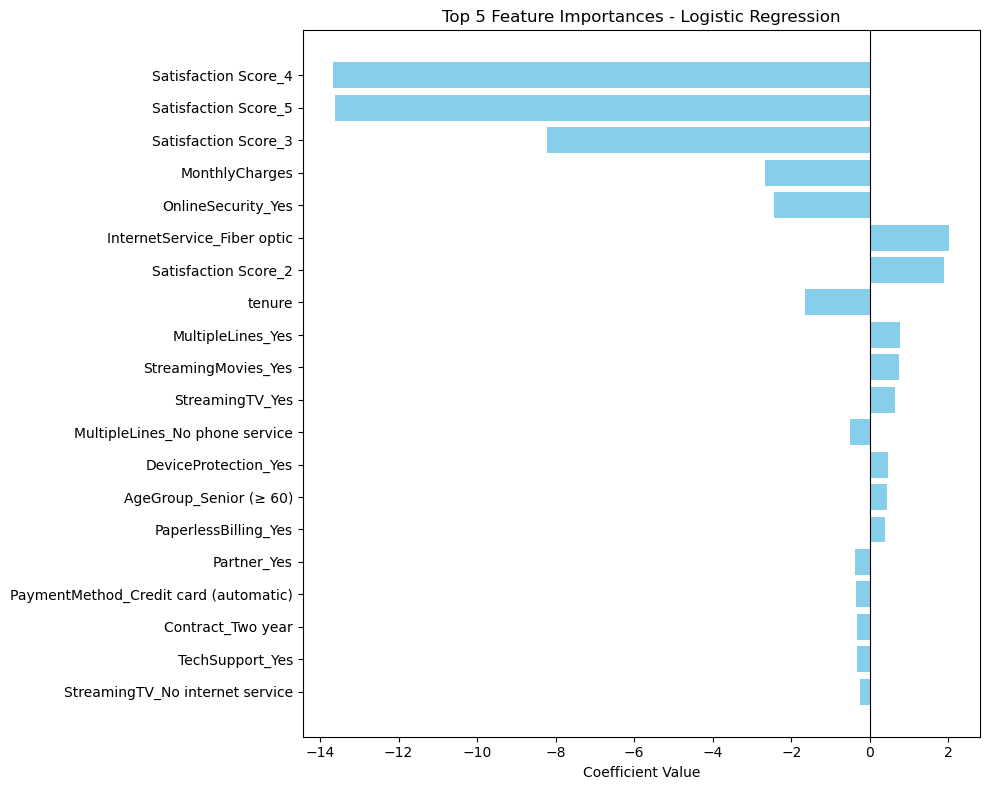

In [221]:
logreg_model = best_model.named_steps["model"]

# Extract encoded categorical feature names
ohe = (
    best_model.named_steps["preprocess"]
    .named_transformers_["cat"]
    .named_steps["onehot"]
)
cat_feature_names = ohe.get_feature_names_out(cat_cols)

all_feature_names = num_cols + cat_feature_names.tolist()

coefficients = logreg_model.coef_[0]

feature_importance_df = pd.DataFrame(
    {
        "Feature": all_feature_names,
        "Coefficient": coefficients,
        "Abs_Coefficient": np.abs(coefficients),
    }
).sort_values(by="Abs_Coefficient", ascending=False)

# Assuming you already have `feature_importance_df` from your trained model
top_features = feature_importance_df.sort_values(
    by="Abs_Coefficient", ascending=False
).head(20)

plt.figure(figsize=(10, 8))
bars = plt.barh(top_features["Feature"], top_features["Coefficient"], color="skyblue")
plt.axvline(0, color="black", linewidth=0.8)
plt.xlabel("Coefficient Value")
plt.title(f"Top 5 Feature Importances - Logistic Regression")
plt.gca().invert_yaxis()  # Puts most important at the top

plt.tight_layout()
plt.show()

<div class="alert alert-info" role="alert">
    Customers with high satisfaction scores, online services (like security and tech support), and longer tenure are less likely to churn, while those with low satisfaction, fiber optic internet, and high monthly charges are more prone to leave
</div>

### Save Model

In [224]:
model_filename = "tuned_logistic_regression.pkl"

with open(model_filename, "wb") as file:
    pickle.dump(best_model, file)

print(f"Model saved to {model_filename}")

Model saved to tuned_logistic_regression.pkl


<div class="alert alert-success" role="alert">
    We save the trained pipeline, which includes both the preprocessing steps and the logistic regression model
</div>

---

# Conclusion
---

In [228]:
df["Churn"].value_counts()

Churn
0    5163
1    1869
Name: count, dtype: int64

In [229]:
1869 * 0.878049

1641.0735809999999

<div class="alert alert-success" role="alert">
    The model correctly identifies 1,641 out of 1,869 actual churned customers, demonstrating strong sensitivity to churn behavior
</div>

## Predict Churn
* Developed and tuned a **Logistic Regression model**.
* **Performance on full dataset**:

  * **F2 Score**: `0.878`
  * **ROC AUC**: `0.987`
* The model correctly predicted **1,611 out of 1,869 actual churners**, demonstrating high recall and strong suitability for real-world churn detection.

## Identify Churn Drivers
**Top churn-increasing factors:**

* Low satisfaction scores (`Satisfaction Score_2`)
* Fiber optic internet (`InternetService_Fiber optic`)
* High monthly charges

**Top churn-reducing factors:**

* High satisfaction scores (`Score 4` and `5`)
* Use of **Online Security**, **Device Protection**, and **Tech Support**
* Longer tenure

These insights can guide retention strategies and personalized interventions.